# Project: Dense Prediction: Monocular Depth Estimation and Semantic Segmentation

### Total points in the project = 120 = 65 (Part 1) + 35 (Part 2) + 20 (Competition)

<img src='https://i.imgur.com/I2rSgxd.png' width=200> <img src='https://i.imgur.com/1oP2EIg.png' width=200>

## Read Carefully!

<hr/>

**Note**: If you are using Google Colab, Make sure that your Colab notebook is a GPU instance. Also, the first time you run the training, the instance might crash for exceeding the allocated memory. This is expected behaviour, especially with large batch sizes. Collab will suggest restarting the session and providing instances with larger memory sizes.

**Note**: This project is more open-ended. Multiple solutions can be considered _correct_. As there already exist implementations of various deep networks for this task on the interweb, **plagiarism will NOT be tolerated**. Your code will be judged for similarity against code available online and other students' code. You are expected to justify every design decision when your project is being evaluated. Any plagiarism detected will lead to a Grade of ZERO WITHOUT ANY WARNINGS. You will be explicitly guided in the notebook to look-up information on internet when needed. 

**Note**: The networks you will design/implement may be much larger than what you have previously designed. Please bring hardware concerns to the attention to the TAs on slack as required. You will need to begin early to test out new ideas/hyperparameters and training will take much longer. Best of luck!

<hr/>

# Competition [20 points]
This project contains two sub-parts (Depth estimation and semantic segmentation) for which you will develop your models. Performance of your models on both the sub-tasks (given validation sets) will be compared against the other students in the class and ranked in the leaderboard. 20 points for grading are reserved for the competition and will be given depending on your position on the leaderboard. Your notebook will be re-run and your pretrained models may also be chosen for further testing for verification. Any form of cheating WILL be caught and will result in TOTAL grade of ZERO without any warnings.

#### **Top 3 winners** will be given food coupons by Prof. Peter Wonka :\)

Good luck!

# Part 1 : Monocular Depth Estimation

## Introduction

- In this part of the project, you are tasked to create a model that **estimates depth from a single input image**. The input is an RGB image and the output is a single channel dense depth map where each pixel is the estimated distance from the 'camera sensor' to an object in the scene in real world units (e.g. in meters). Depth from a single image is a fundemental vision task with many useful applications including scene understanding and reconstruction.

- You are to develop a convolutional neural network (CNN) that formulates the problem as a regression of the depth map from a single RGB image. 

- In this section, we provide all the source code needed for loading and evaluating your model.  You will reuse the model in the next section

- Your task in this section is to modify the code in order to:
    - Define a [UNet](https://arxiv.org/abs/1505.04597) model that takes an RGB image and outputs a single channel depth map. **[25 points]**
    - Define an approprate loss function. **[15 points]**
    - Tune the model to achieve an RMSE of **0.035** or less on the given validation set. **[25 points]**


## Setup

In [1]:
!pip install tqdm datasets timm

## Downloading data

In [2]:
import datasets
ds = datasets.load_dataset("shariqfarooq/cs323_densepred_depth")  # DO NOT change this

C:\Users\WANGH0M\AppData\Local\anaconda3\envs\DLVC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'depth'],
        num_rows: 25356
    })
    test: Dataset({
        features: ['image', 'depth'],
        num_rows: 518
    })
})

In [4]:
ds["train"], ds["train"][0], ds["train"][0]["image"]

(Dataset({
     features: ['image', 'depth'],
     num_rows: 25356
 }),
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
  'depth': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>},
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>)

In [5]:
from torchvision import transforms as T
from torch.utils.data import DataLoader


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

image_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

depth_transforms = T.Compose([T.ToTensor()])

def transform(batch):
  batch['image'] = ([image_transforms(im) for im in batch['image']])
  batch['depth'] = [depth_transforms(d)[:1] for d in batch['depth']]
  return batch

ds.set_transform(transform) ##Huinote: transfer above PIL data into tensor


In [6]:
ds['train'][0]['image'].shape, ds['train'][0]['depth'].shape ##ds['train'][0] is only 1 image

(torch.Size([3, 256, 256]), torch.Size([1, 128, 128]))

In [7]:
ds['train'] ## 25356 images

Dataset({
    features: ['image', 'depth'],
    num_rows: 25356
})

## Sanity check 

torch.Size([3, 260, 1292]) torch.Size([3, 132, 652])


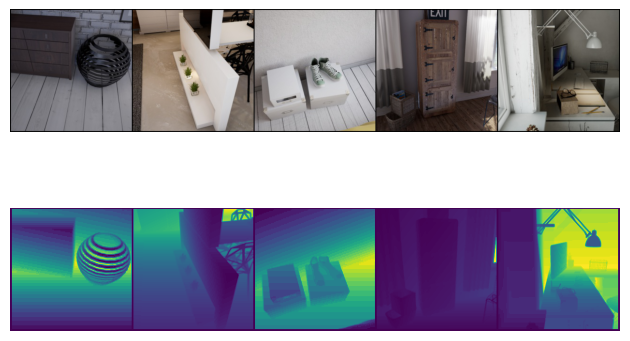

In [8]:
# Examine training data
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision.utils import make_grid

def denorm_imagenet(x):
    mean, std = torch.tensor(IMAGENET_MEAN).to(x.device), torch.tensor(IMAGENET_STD).to(x.device)
    if x.ndim == 3: ##Hui: chanel is 3 RGB
        mean, std = mean[:, None, None], std[:, None, None]
        #print('x.ndim==3: ', mean, std)
    elif x.ndim == 4:
        mean, std = mean[None, :, None, None], std[None, :,  None, None]
        #print('x.ndim==4: ', mean, std)
    ##Hui: above computed std and mean are always the same for different iteration [1,2,3,4,5]
    ## mean: tensor([[[0.4850]], [[0.4560]], [[0.4060]]])
    ## std: tensor([[[0.2290]], [[0.2240]], [[0.2250]]])
    return x * std + mean


def show_example_data(dataset, split='train', num=5):
    im_stacked = []    ##Hui: first 5 images
    depth_stacked = [] ##Hui: first 5 depths
    for i in range(num):
        sample = dataset[split][i]
        im_stacked.append(denorm_imagenet(sample['image'])) ##Hui: all chanel is 3 RGB, x.ndim==3
        depth_stacked.append(sample['depth'])
    
    im_stacked = make_grid(torch.stack(im_stacked), nrow=num)
    depth_stacked = make_grid(torch.stack(depth_stacked), nrow=num, normalize=True, scale_each=True)

    fig, ax = plt.subplots(2, 1)
    print(im_stacked.shape, depth_stacked.shape)
    ax[0].imshow(im_stacked.permute(1, 2, 0)) ##Hui: im_stacked is a tensor (C,H,W), imshow need a tensor (H,W,C)
    ax[1].imshow(depth_stacked[0])
    for a in ax:
        a.axis('off')
    
    plt.tight_layout()
    plt.show()

show_example_data(ds)

## Getting started with timm

[`timm`](https://timm.fast.ai/) is a popular deep-learning library created by [Ross Wightman](https://twitter.com/wightmanr) and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results. 

We will be using `timm` to load encoder backbones pretrained on ImageNet so we don't have to define encoder architectures (that you did in previous projects) or start training from scratch



In [9]:
# timm example for loading any encoder architecture
import timm
import torch

model = timm.create_model('resnet34') # load resnet34 architecture
x     = torch.randn(1, 3, 224, 224)  # create random input tensor
model(x).shape

torch.Size([1, 1000])

In [10]:
# You can also load a pretrained model
pretrained_resnet_34 = timm.create_model('resnet34', pretrained=True)

In [11]:
# List all available models
avail_pretrained_models = timm.list_models(pretrained=True)

print(f"Number of available pretrained models: {len(avail_pretrained_models)}")
print(f"First 5 models: {avail_pretrained_models[:5]}")

Number of available pretrained models: 1242
First 5 models: ['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k']


As you can see, we have vast variety of available pretrained models (750+)! In this project, you are free to choose any one of them

In [12]:
# Searching through 750+ models can be a pain. timm provides glob filtering so we can filter the models by name
# Lets list all the models that have 'efficientnet' in their name
all_efficientnet_models = timm.list_models('*efficientnet*', pretrained=True)
all_efficientnet_models

['efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k',
 'gc_efficientnetv2_rw_t.agc_in1k',
 'tf_efficientnet_b0.aa_in1k',
 'tf_efficientnet_b0.ap_in1k',
 'tf_efficientnet_b0.in1k',
 'tf_efficientnet_b0.ns_jft_in1k',
 'tf_efficientnet_b1.aa_in1k',
 'tf_efficientnet_b1.ap_in1k',
 'tf_efficientnet_b1.in1k',
 'tf_efficientnet_b1.ns_jft_in1k',
 'tf_efficientnet_b2.aa_in1k',
 'tf_efficientnet_b2.ap_in1k',
 'tf_efficientnet_b2.in1k',
 'tf_efficientnet_b2.ns_jft_in1k',
 'tf_e

### Feature extraction with timm

In [13]:
BACKBONE = "resnet34"  # TODO: Change this to your desired backbone

In [14]:
# Let's tell timm that we only need features from various from various layers (and not final ImageNet class logits)
encoder = timm.create_model(BACKBONE, pretrained=True, features_only=True)

In [15]:
print("Channel info:", encoder.feature_info.channels())
x = torch.rand(1, 3, 224, 224)
out = encoder(x) ##Hui: type of out is list, can not use .shape nor .size, but only len
print(len(out))
assert type(out) is list ##Hui: checks whether the variable `out` is a list. If not, then an exception will be raised
[o.shape for o in out]

Channel info: [64, 64, 128, 256, 512]
5


[torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7])]

#### Note that now we are able to get multi-scale features from our encoder. You will use this to build your Unet

## Model [25 points]

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model


class Unet(nn.Module):
    """
    TODO: Complete the docstring of the Unet class (description, parameters, returns, etc.)
    backbone='resnet50': Use the ResNet50 model
    num_classes=1: output channel is only one depth
    final_activation=nn.ReLU(): choose ReLU as final activation
    in_channels=3:  input an image as a tensor of 3 channels RGB, 
    Unet: a class with an encoder and 4 decoders
    """

    def __init__(
            self,
            backbone='resnet50',
            num_classes=1,
            final_activation=nn.ReLU(), ##nn.Identity(), # TODO: Change this to your desired final activation
            # TODO: Add any other relevant args you need
            in_channels=3):
        
        super().__init__()
        # TODO: Complete the definition of the Unet class
        # Use timm to load the encoder backbone with imagenet pretrained weights
        # encoder **must** return a list of feature maps that will be used by the decoder
        self.encoder = create_model(backbone, pretrained=True, features_only=True, in_chans=in_channels)
        
        self.decoder4 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True)
        )
        
        self.decoder3 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True)
        )
        
        self.decoder2 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True)
        )

        self.decoder1 = nn.Sequential(
        nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1)
        )

        self.final_activation = final_activation
        
        # Initialize the weights
        self._initialize_weights()
    
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor):
        # TODO: Complete the forward function
        ## print(len(self.encoder(x))) ###==5
        ## x1:[1, 64, 128, 128]; x2:[1, 64, 64, 64]; x3:[1, 128, 32, 32]; x4:[1, 256, 16, 16]; x5:[1, 512, 8, 8]
        x1, x2, x3, x4, x5 = self.encoder(x)

        # Decoder
        y4 = self.decoder4(x5) + x4
        y3 = self.decoder3(y4) + x3
        y2 = self.decoder2(y3) + x2
        y1 = self.decoder1(y2)
        x = self.final_activation(y1)
        return x

In [17]:
model = Unet('resnet34')

In [18]:
# Always perform a sanity check on the models you define
x = torch.randn(1, 3, 256, 256)
out = model(x)
print("Input shape", x.shape)
print("Output shape", out.shape)

Input shape torch.Size([1, 3, 256, 256])
Output shape torch.Size([1, 1, 128, 128])


In [19]:
# Move to GPUs. Using all GPUs available by default. You can change this.
model = nn.DataParallel(model)
model = model.cuda()

## Loss Function [15 points]

Define a loss function that is suitable for the depth estimation. Look up the latest papers, for example on [PapersWithCode leaderboards](https://paperswithcode.com/sota/monocular-depth-estimation-on-nyu-depth-v2).
Why will the current loss not work? Submit the answer in the notebook.

In [63]:
import torch
import torch.nn.functional as F


def loss_fn(pred_y, y):
    return torch.mean(y.sub(pred_y))

"""
from paper "Unleashing Text-to-Image Diffusion Models for Visual Perception 2023" in the leaderboards
"We use the cross-entropy loss for both semantic segmentation and referring image segmentation, 
while the Scale-Invariant loss (SI) [14] is used for depth estimation."
"""
def loss_SI(pred_y, y): 
    """Scale-Invariant loss (SI)
    Predicted depth map and ground truth depth map have the same dimensions (N, C, H, W). 
    It takes the absolute difference between the predicted and ground truth depth maps and applies a threshold to the difference. 
    If the absolute difference is less than the threshold, the loss is calculated as 0.5 * (difference ** 2). 
    If the absolute difference is greater than the threshold, the loss is difference - 0.5 * threshold. 
    The delta parameter is used to avoid division by zero in the threshold calculation.
    """
    abs_diff = torch.abs(pred_y - y)

    threshold = 1.0
    delta = 0.1
    si_loss = torch.mean(torch.where(abs_diff < threshold, 0.5 * (abs_diff ** 2), abs_diff - 0.5 * threshold))

    return si_loss

## Training + Evaluation [25 points]

Tune the hyperparameters and the architecture to achieve the target RMSE

In [64]:
### Hyperparameters
# TODO: Change these to your desired hyperparameters

epochs = 10
batch_size = 32
learning_rate = 0.01 #10

###Hui running tests:
### model_n1_bs32_lr0.1, Validation_RMSE = 0.27746602569582274
### model_n1_bs32_lr10, Validation_RMSE = 0.27746602569582274



# workers = 4 # The number of parallel processes used to read data. Increase this if you have more cores.
train_loader = DataLoader(ds['train'], batch_size=batch_size, shuffle=True)#, num_workers=workers) ##Hui: will have bug, then comment
test_loader = DataLoader(ds['test'], batch_size=batch_size, shuffle=False)#, num_workers=workers)

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
import numpy as np
from tqdm.auto import tqdm
import gc
import os

### When `tqdm` is used, a progress bar is displayed in the console that shows how much of the process has been completed. 
### The progress bar includes information such as the number of iterations completed, 
### the estimated time remaining, and the current rate of progress.

run_id = f'model_n{epochs}_bs{batch_size}_lr{learning_rate}'; print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

# TODO: Experiment with different optimizers and learning rate schedulers
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=learning_rate * 0.1, ##Hui: *0.1
                                                steps_per_epoch=len(train_loader), 
                                                epochs=epochs)


class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0



ITER_PER_EPOCH = len(train_loader)
TOTAL_STEPS = ITER_PER_EPOCH * epochs


metrics = RMSE()

@torch.no_grad()
def validate(model, valid_loader):
    model.eval()
    metrics.reset()
    for i, (sample) in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validating'):
        x, y = sample['image'].float().cuda(), sample['depth'].numpy()
        y_pred = model(x).detach().cpu().numpy()
        metrics.add_batch(y_pred, y)
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get())) ##Hui: =0.27746602569582274 (always)


# One validation before we start training (good practice to catch errors early)
validate(model, test_loader) ##Hui: len(test_loader)==17
pbar = tqdm(total=TOTAL_STEPS, desc='Training')
for epoch in range(epochs):
    model.train()
    N = len(train_loader) ##Hui: =793

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['depth'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        loss = loss_SI(y_pred, y) ##Hui: replace loss_fn by loss_SI

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        # learning rate scheduler step.
        # TODO: location of this call might change depending on your choice of scheduler. 
        scheduler.step()

        pbar.update(1)
        # Report progress. Add any extra logging info here
        pbar.set_postfix({'epoch': f'{epoch+1}/{N}', 'loss': loss.item(), 'epoch%': "{0:.1f}%".format(100*(i+1)/N)})
            
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; gc.collect()
    
    # Validation after each epoch
    validate(model, test_loader)
    

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training model_n10_bs32_lr0.01



Validating: 100%|██████████| 17/17 [00:03<00:00,  5.50it/s]



Validation RMSE 0.25563138773377064



Training: 100%|██████████| 4758/4758 [27:40<00:00,  2.87it/s, epoch=6/793, loss=0.000584, epoch%=100.0%]

Training:   1%|          | 40/7930 [00:10<34:37,  3.80it/s, epoch=1/793, loss=0.0325, epoch%=4.9%]


Training:   1%|          | 80/7930 [00:20<34:08,  3.83it/s, epoch=1/793, loss=0.0231, epoch%=10.0%]


Training:   2%|▏         | 119/7930 [00:31<33:54,  3.84it/s, epoch=1/793, loss=0.0134, epoch%=15.0%]


Training:   2%|▏         | 158/7930 [00:41<33:25,  3.87it/s, epoch=1/793, loss=0.0163, epoch%=19.9%] 


Training:   2%|▏         | 197/7930 [00:51<34:13,  3.77it/s, epoch=1/793, loss=0.0104, epoch%=24.8%]


Training:   3%|▎         | 236/7930 [01:01<33:47,  3.79it/s, epoch=1/793, loss=0.0107, epoch%=29.8%] 


Training:   3%|▎         | 275/7930 [01:12<33:06,  3.85it/s, epoch=1/793, loss=0.01, epoch%=34.7%]  


Training:   4%|▍         | 314/7930 [01:22<33:18,  3.81it/s, epoch=1/793, loss=0.00653, epoch%=39.6%]


Training:   4%|▍         | 353/7930 [01:32<32:41,  3.86it/s, epoch=1/793, loss=0.00488, epoch%=44.5%]


Training:   5%|▍         | 392/7930 [01:42<31:56,  3.93it/s, epoch=1/793, loss=0.00523, epoch%=49.4%]


Training:   5%|▌         | 431/7930 [01:52<32:03,  3.90it/s, epoch=1/793, loss=0.00702, epoch%=54.4%]


Training:   6%|▌         | 470/7930 [02:02<32:14,  3.86it/s, epoch=1/793, loss=0.00392, epoch%=59.3%]


Training:   6%|▋         | 509/7930 [02:13<31:57,  3.87it/s, epoch=1/793, loss=0.00465, epoch%=64.2%]


Training:   7%|▋         | 548/7930 [02:23<32:48,  3.75it/s, epoch=1/793, loss=0.00389, epoch%=69.1%]


Training:   7%|▋         | 587/7930 [02:33<32:17,  3.79it/s, epoch=1/793, loss=0.0052, epoch%=74.0%] 


Training:   8%|▊         | 626/7930 [02:43<31:54,  3.82it/s, epoch=1/793, loss=0.00399, epoch%=78.9%]


Training:   8%|▊         | 665/7930 [02:53<31:54,  3.80it/s, epoch=1/793, loss=0.00627, epoch%=83.9%]


Training:   9%|▉         | 704/7930 [03:04<31:07,  3.87it/s, epoch=1/793, loss=0.00363, epoch%=88.8%]


Training:   9%|▉         | 743/7930 [03:14<31:34,  3.79it/s, epoch=1/793, loss=0.00372, epoch%=93.7%]


Training:  10%|▉         | 782/7930 [03:24<31:31,  3.78it/s, epoch=1/793, loss=0.00394, epoch%=98.6%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.06it/s], epoch=1/793, loss=0.00738, epoch%=100.0%]




Validation RMSE 0.08039921625067811


Training:  10%|█         | 832/7930 [03:40<30:32,  3.87it/s, epoch=2/793, loss=0.00404, epoch%=4.9%]


Training:  11%|█         | 871/7930 [03:50<31:09,  3.78it/s, epoch=2/793, loss=0.00292, epoch%=9.8%]


Training:  11%|█▏        | 910/7930 [04:00<31:04,  3.76it/s, epoch=2/793, loss=0.00325, epoch%=14.8%]


Training:  12%|█▏        | 949/7930 [04:11<29:59,  3.88it/s, epoch=2/793, loss=0.00332, epoch%=19.7%]


Training:  12%|█▏        | 988/7930 [04:21<30:39,  3.77it/s, epoch=2/793, loss=0.00553, epoch%=24.6%]


Training:  13%|█▎        | 1027/7930 [04:31<30:50,  3.73it/s, epoch=2/793, loss=0.00328, epoch%=29.4%]


Training:  13%|█▎        | 1065/7930 [04:41<29:44,  3.85it/s, epoch=2/793, loss=0.00264, epoch%=34.3%]


Training:  14%|█▍        | 1104/7930 [04:51<29:27,  3.86it/s, epoch=2/793, loss=0.00455, epoch%=39.1%]


Training:  14%|█▍        | 1142/7930 [05:01<30:58,  3.65it/s, epoch=2/793, loss=0.00231, epoch%=44.0%]


Training:  15%|█▍        | 1181/7930 [05:11<29:51,  3.77it/s, epoch=2/793, loss=0.00286, epoch%=48.8%]


Training:  15%|█▌        | 1219/7930 [05:21<29:01,  3.85it/s, epoch=2/793, loss=0.00287, epoch%=53.7%]


Training:  16%|█▌        | 1258/7930 [05:31<28:58,  3.84it/s, epoch=2/793, loss=0.00378, epoch%=58.5%]


Training:  16%|█▋        | 1296/7930 [05:41<28:27,  3.89it/s, epoch=2/793, loss=0.00256, epoch%=63.4%]


Training:  17%|█▋        | 1335/7930 [05:51<29:09,  3.77it/s, epoch=2/793, loss=0.00402, epoch%=68.2%]


Training:  17%|█▋        | 1373/7930 [06:01<28:09,  3.88it/s, epoch=2/793, loss=0.00228, epoch%=73.1%]


Training:  18%|█▊        | 1412/7930 [06:11<28:21,  3.83it/s, epoch=2/793, loss=0.00261, epoch%=77.9%]


Training:  18%|█▊        | 1450/7930 [06:21<28:25,  3.80it/s, epoch=2/793, loss=0.003, epoch%=82.8%]  


Training:  19%|█▉        | 1489/7930 [06:31<27:27,  3.91it/s, epoch=2/793, loss=0.00315, epoch%=87.6%]


Training:  19%|█▉        | 1527/7930 [06:41<27:43,  3.85it/s, epoch=2/793, loss=0.00249, epoch%=92.6%]


Training:  20%|█▉        | 1566/7930 [06:51<27:38,  3.84it/s, epoch=2/793, loss=0.0028, epoch%=97.4%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.03it/s]s, epoch=2/793, loss=0.00249, epoch%=100.0%]




Validation RMSE 0.06858291057611349


Training:  20%|██        | 1625/7930 [07:10<26:41,  3.94it/s, epoch=3/793, loss=0.00175, epoch%=4.8%]


Training:  21%|██        | 1664/7930 [07:20<26:55,  3.88it/s, epoch=3/793, loss=0.00197, epoch%=9.7%]


Training:  21%|██▏       | 1702/7930 [07:30<27:32,  3.77it/s, epoch=3/793, loss=0.00249, epoch%=14.6%]


Training:  22%|██▏       | 1741/7930 [07:40<26:42,  3.86it/s, epoch=3/793, loss=0.00165, epoch%=19.4%]


Training:  22%|██▏       | 1779/7930 [07:50<27:08,  3.78it/s, epoch=3/793, loss=0.0022, epoch%=24.3%] 


Training:  23%|██▎       | 1818/7930 [08:00<28:10,  3.62it/s, epoch=3/793, loss=0.00147, epoch%=29.1%]


Training:  23%|██▎       | 1856/7930 [08:10<26:17,  3.85it/s, epoch=3/793, loss=0.00252, epoch%=34.0%]


Training:  24%|██▍       | 1895/7930 [08:20<25:58,  3.87it/s, epoch=3/793, loss=0.00137, epoch%=38.8%]


Training:  24%|██▍       | 1933/7930 [08:30<25:59,  3.85it/s, epoch=3/793, loss=0.00358, epoch%=43.8%]


Training:  25%|██▍       | 1972/7930 [08:40<25:47,  3.85it/s, epoch=3/793, loss=0.00217, epoch%=48.5%]


Training:  25%|██▌       | 2010/7930 [08:50<25:49,  3.82it/s, epoch=3/793, loss=0.00243, epoch%=53.5%]


Training:  26%|██▌       | 2049/7930 [09:00<25:28,  3.85it/s, epoch=3/793, loss=0.00268, epoch%=58.3%]


Training:  26%|██▋       | 2087/7930 [09:10<25:50,  3.77it/s, epoch=3/793, loss=0.00117, epoch%=63.2%]


Training:  27%|██▋       | 2126/7930 [09:21<25:46,  3.75it/s, epoch=3/793, loss=0.00172, epoch%=68.0%]


Training:  27%|██▋       | 2164/7930 [09:31<25:03,  3.84it/s, epoch=3/793, loss=0.00144, epoch%=72.9%]


Training:  28%|██▊       | 2203/7930 [09:41<24:57,  3.82it/s, epoch=3/793, loss=0.00184, epoch%=77.7%]


Training:  28%|██▊       | 2241/7930 [09:51<25:00,  3.79it/s, epoch=3/793, loss=0.001, epoch%=82.6%]  


Training:  29%|██▉       | 2280/7930 [10:01<24:53,  3.78it/s, epoch=3/793, loss=0.00144, epoch%=87.4%]


Training:  29%|██▉       | 2318/7930 [10:11<25:35,  3.66it/s, epoch=3/793, loss=0.00227, epoch%=92.3%]


Training:  30%|██▉       | 2357/7930 [10:22<24:21,  3.81it/s, epoch=3/793, loss=0.00176, epoch%=97.1%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]s, epoch=3/793, loss=0.00205, epoch%=100.0%]




Validation RMSE 0.05808704695990213


Training:  30%|███       | 2418/7930 [10:40<24:01,  3.82it/s, epoch=4/793, loss=0.00152, epoch%=4.8%]


Training:  31%|███       | 2457/7930 [10:50<23:48,  3.83it/s, epoch=4/793, loss=0.00184, epoch%=9.7%]


Training:  31%|███▏      | 2495/7930 [11:00<23:21,  3.88it/s, epoch=4/793, loss=0.00188, epoch%=14.6%]


Training:  32%|███▏      | 2534/7930 [11:10<23:10,  3.88it/s, epoch=4/793, loss=0.00136, epoch%=19.4%]


Training:  32%|███▏      | 2572/7930 [11:20<22:56,  3.89it/s, epoch=4/793, loss=0.00113, epoch%=24.3%]


Training:  33%|███▎      | 2611/7930 [11:30<24:35,  3.60it/s, epoch=4/793, loss=0.00138, epoch%=29.1%]


Training:  33%|███▎      | 2649/7930 [11:40<22:53,  3.84it/s, epoch=4/793, loss=0.00229, epoch%=34.0%]


Training:  34%|███▍      | 2688/7930 [11:50<22:20,  3.91it/s, epoch=4/793, loss=0.00256, epoch%=38.8%]


Training:  34%|███▍      | 2726/7930 [12:00<22:10,  3.91it/s, epoch=4/793, loss=0.0013, epoch%=43.8%] 


Training:  35%|███▍      | 2765/7930 [12:10<22:11,  3.88it/s, epoch=4/793, loss=0.00112, epoch%=48.5%]


Training:  35%|███▌      | 2803/7930 [12:20<22:18,  3.83it/s, epoch=4/793, loss=0.0014, epoch%=53.5%] 


Training:  36%|███▌      | 2842/7930 [12:30<21:58,  3.86it/s, epoch=4/793, loss=0.000953, epoch%=58.3%]


Training:  36%|███▋      | 2880/7930 [12:40<21:35,  3.90it/s, epoch=4/793, loss=0.00122, epoch%=63.2%] 


Training:  37%|███▋      | 2919/7930 [12:51<22:17,  3.75it/s, epoch=4/793, loss=0.00149, epoch%=68.0%]


Training:  37%|███▋      | 2957/7930 [13:00<21:11,  3.91it/s, epoch=4/793, loss=0.000967, epoch%=72.9%]


Training:  38%|███▊      | 2996/7930 [13:11<21:27,  3.83it/s, epoch=4/793, loss=0.0016, epoch%=77.7%]


Training:  38%|███▊      | 3034/7930 [13:21<21:12,  3.85it/s, epoch=4/793, loss=0.00116, epoch%=82.6%]


Training:  39%|███▉      | 3073/7930 [13:31<20:55,  3.87it/s, epoch=4/793, loss=0.00131, epoch%=87.4%]


Training:  39%|███▉      | 3111/7930 [13:41<20:47,  3.86it/s, epoch=4/793, loss=0.00153, epoch%=92.3%] 


Training:  40%|███▉      | 3150/7930 [13:51<21:00,  3.79it/s, epoch=4/793, loss=0.00105, epoch%=97.1%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.10it/s]s, epoch=4/793, loss=0.00147, epoch%=100.0%]




Validation RMSE 0.04264399249654674


Training:  40%|████      | 3211/7930 [14:10<20:56,  3.76it/s, epoch=5/793, loss=0.000872, epoch%=4.8%]


Training:  41%|████      | 3249/7930 [14:20<20:26,  3.82it/s, epoch=5/793, loss=0.00102, epoch%=9.7%]


Training:  41%|████▏     | 3287/7930 [14:30<20:47,  3.72it/s, epoch=5/793, loss=0.00127, epoch%=14.5%] 


Training:  42%|████▏     | 3325/7930 [14:40<20:08,  3.81it/s, epoch=5/793, loss=0.00049, epoch%=19.3%]


Training:  42%|████▏     | 3363/7930 [14:50<19:51,  3.83it/s, epoch=5/793, loss=0.00137, epoch%=24.1%]


Training:  43%|████▎     | 3401/7930 [15:00<20:04,  3.76it/s, epoch=5/793, loss=0.00115, epoch%=28.9%] 


Training:  43%|████▎     | 3439/7930 [15:10<19:24,  3.86it/s, epoch=5/793, loss=0.00107, epoch%=33.7%] 


Training:  44%|████▍     | 3477/7930 [15:20<19:33,  3.79it/s, epoch=5/793, loss=0.00113, epoch%=38.5%] 


Training:  44%|████▍     | 3515/7930 [15:30<19:26,  3.78it/s, epoch=5/793, loss=0.000985, epoch%=43.3%]


Training:  45%|████▍     | 3553/7930 [15:40<18:56,  3.85it/s, epoch=5/793, loss=0.000879, epoch%=48.0%]


Training:  45%|████▌     | 3591/7930 [15:50<18:59,  3.81it/s, epoch=5/793, loss=0.00104, epoch%=52.8%] 


Training:  46%|████▌     | 3629/7930 [16:00<18:59,  3.77it/s, epoch=5/793, loss=0.000702, epoch%=57.6%]


Training:  46%|████▌     | 3667/7930 [16:10<18:41,  3.80it/s, epoch=5/793, loss=0.00102, epoch%=62.4%]


Training:  47%|████▋     | 3705/7930 [16:20<18:35,  3.79it/s, epoch=5/793, loss=0.00093, epoch%=67.2%]


Training:  47%|████▋     | 3743/7930 [16:30<18:13,  3.83it/s, epoch=5/793, loss=0.00102, epoch%=72.0%] 


Training:  48%|████▊     | 3781/7930 [16:40<17:39,  3.92it/s, epoch=5/793, loss=0.000698, epoch%=76.8%]


Training:  48%|████▊     | 3819/7930 [16:50<17:51,  3.84it/s, epoch=5/793, loss=0.000931, epoch%=81.6%]


Training:  49%|████▊     | 3857/7930 [16:59<17:44,  3.83it/s, epoch=5/793, loss=0.000451, epoch%=86.4%]


Training:  49%|████▉     | 3895/7930 [17:09<17:35,  3.82it/s, epoch=5/793, loss=0.00121, epoch%=91.2%] 


Training:  50%|████▉     | 3933/7930 [17:19<17:05,  3.90it/s, epoch=5/793, loss=0.000854, epoch%=96.0%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.19it/s]s, epoch=5/793, loss=0.000787, epoch%=100.0%]




Validation RMSE 0.03932381787519539


Training:  50%|█████     | 4004/7930 [17:40<16:41,  3.92it/s, epoch=6/793, loss=0.000588, epoch%=4.8%]


Training:  51%|█████     | 4042/7930 [17:50<16:36,  3.90it/s, epoch=6/793, loss=0.000909, epoch%=9.7%]


Training:  51%|█████▏    | 4080/7930 [18:00<16:47,  3.82it/s, epoch=6/793, loss=0.000619, epoch%=14.5%]


Training:  52%|█████▏    | 4118/7930 [18:10<16:38,  3.82it/s, epoch=6/793, loss=0.000747, epoch%=19.3%]


Training:  52%|█████▏    | 4156/7930 [18:20<16:16,  3.86it/s, epoch=6/793, loss=0.000532, epoch%=24.1%]


Training:  53%|█████▎    | 4194/7930 [18:30<16:17,  3.82it/s, epoch=6/793, loss=0.000817, epoch%=28.9%]


Training:  53%|█████▎    | 4232/7930 [18:40<16:14,  3.80it/s, epoch=6/793, loss=0.000657, epoch%=33.7%]


Training:  54%|█████▍    | 4270/7930 [18:50<15:34,  3.92it/s, epoch=6/793, loss=0.00108, epoch%=38.5%] 


Training:  54%|█████▍    | 4308/7930 [18:59<15:40,  3.85it/s, epoch=6/793, loss=0.000751, epoch%=43.3%]


Training:  55%|█████▍    | 4346/7930 [19:09<15:21,  3.89it/s, epoch=6/793, loss=0.000977, epoch%=48.0%]


Training:  55%|█████▌    | 4384/7930 [19:19<15:06,  3.91it/s, epoch=6/793, loss=0.000639, epoch%=52.8%]


Training:  56%|█████▌    | 4422/7930 [19:29<15:19,  3.82it/s, epoch=6/793, loss=0.000656, epoch%=57.6%]


Training:  56%|█████▌    | 4460/7930 [19:39<15:17,  3.78it/s, epoch=6/793, loss=0.000632, epoch%=62.4%]


Training:  57%|█████▋    | 4498/7930 [19:49<14:33,  3.93it/s, epoch=6/793, loss=0.000911, epoch%=67.2%]


Training:  57%|█████▋    | 4536/7930 [19:58<14:42,  3.85it/s, epoch=6/793, loss=0.000725, epoch%=72.0%]


Training:  58%|█████▊    | 4574/7930 [20:08<14:21,  3.90it/s, epoch=6/793, loss=0.000691, epoch%=76.8%]


Training:  58%|█████▊    | 4612/7930 [20:18<14:31,  3.81it/s, epoch=6/793, loss=0.00102, epoch%=81.6%]


Training:  59%|█████▊    | 4650/7930 [20:28<13:53,  3.94it/s, epoch=6/793, loss=0.000627, epoch%=86.4%]


Training:  59%|█████▉    | 4688/7930 [20:38<14:08,  3.82it/s, epoch=6/793, loss=0.000577, epoch%=91.2%]


Training:  60%|█████▉    | 4726/7930 [20:48<13:56,  3.83it/s, epoch=6/793, loss=0.000776, epoch%=96.0%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.30it/s]s, epoch=6/793, loss=0.000528, epoch%=100.0%]




Validation RMSE 0.035817488984313146


Training:  60%|██████    | 4797/7930 [21:09<13:33,  3.85it/s, epoch=7/793, loss=0.000852, epoch%=4.8%]


Training:  61%|██████    | 4835/7930 [21:19<13:35,  3.80it/s, epoch=7/793, loss=0.000644, epoch%=9.7%]


Training:  61%|██████▏   | 4873/7930 [21:29<13:13,  3.85it/s, epoch=7/793, loss=0.000798, epoch%=14.5%]


Training:  62%|██████▏   | 4911/7930 [21:39<12:47,  3.94it/s, epoch=7/793, loss=0.000899, epoch%=19.3%]


Training:  62%|██████▏   | 4949/7930 [21:48<12:47,  3.89it/s, epoch=7/793, loss=0.000523, epoch%=24.1%]


Training:  63%|██████▎   | 4987/7930 [21:58<12:42,  3.86it/s, epoch=7/793, loss=0.000564, epoch%=28.9%]


Training:  63%|██████▎   | 5025/7930 [22:08<12:34,  3.85it/s, epoch=7/793, loss=0.000745, epoch%=33.7%]


Training:  64%|██████▍   | 5063/7930 [22:18<12:05,  3.95it/s, epoch=7/793, loss=0.000634, epoch%=38.5%]


Training:  64%|██████▍   | 5101/7930 [22:28<12:19,  3.82it/s, epoch=7/793, loss=0.000472, epoch%=43.3%]


Training:  65%|██████▍   | 5139/7930 [22:38<12:00,  3.88it/s, epoch=7/793, loss=0.000708, epoch%=48.0%]


Training:  65%|██████▌   | 5177/7930 [22:48<11:39,  3.94it/s, epoch=7/793, loss=0.0005, epoch%=52.8%]  


Training:  66%|██████▌   | 5215/7930 [22:57<11:37,  3.89it/s, epoch=7/793, loss=0.000592, epoch%=57.6%]


Training:  66%|██████▌   | 5253/7930 [23:07<11:38,  3.83it/s, epoch=7/793, loss=0.000563, epoch%=62.4%]


Training:  67%|██████▋   | 5291/7930 [23:17<11:28,  3.83it/s, epoch=7/793, loss=0.000626, epoch%=67.2%]


Training:  67%|██████▋   | 5329/7930 [23:27<11:14,  3.86it/s, epoch=7/793, loss=0.000373, epoch%=72.0%]


Training:  68%|██████▊   | 5367/7930 [23:37<10:55,  3.91it/s, epoch=7/793, loss=0.000481, epoch%=76.8%]


Training:  68%|██████▊   | 5405/7930 [23:47<11:02,  3.81it/s, epoch=7/793, loss=0.000411, epoch%=81.6%]


Training:  69%|██████▊   | 5443/7930 [23:56<10:41,  3.87it/s, epoch=7/793, loss=0.000748, epoch%=86.4%]


Training:  69%|██████▉   | 5481/7930 [24:06<10:32,  3.87it/s, epoch=7/793, loss=0.00055, epoch%=91.2%] 


Training:  70%|██████▉   | 5519/7930 [24:16<10:20,  3.88it/s, epoch=7/793, loss=0.000791, epoch%=96.0%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.33it/s]s, epoch=7/793, loss=0.000345, epoch%=100.0%]




Validation RMSE 0.03429600679704758


Training:  70%|███████   | 5590/7930 [24:37<10:01,  3.89it/s, epoch=8/793, loss=0.000463, epoch%=4.8%]


Training:  71%|███████   | 5628/7930 [24:47<09:53,  3.88it/s, epoch=8/793, loss=0.000376, epoch%=9.7%]


Training:  71%|███████▏  | 5666/7930 [24:57<09:49,  3.84it/s, epoch=8/793, loss=0.000396, epoch%=14.5%]


Training:  72%|███████▏  | 5704/7930 [25:07<09:47,  3.79it/s, epoch=8/793, loss=0.000543, epoch%=19.3%]


Training:  72%|███████▏  | 5742/7930 [25:17<09:21,  3.90it/s, epoch=8/793, loss=0.000756, epoch%=24.1%]


Training:  73%|███████▎  | 5780/7930 [25:26<09:15,  3.87it/s, epoch=8/793, loss=0.000656, epoch%=28.9%]


Training:  73%|███████▎  | 5818/7930 [25:36<09:13,  3.81it/s, epoch=8/793, loss=0.000624, epoch%=33.7%]


Training:  74%|███████▍  | 5856/7930 [25:46<08:55,  3.87it/s, epoch=8/793, loss=0.00041, epoch%=38.5%] 


Training:  74%|███████▍  | 5894/7930 [25:56<08:45,  3.87it/s, epoch=8/793, loss=0.000486, epoch%=43.3%]


Training:  75%|███████▍  | 5932/7930 [26:06<08:43,  3.81it/s, epoch=8/793, loss=0.000457, epoch%=48.0%]


Training:  75%|███████▌  | 5970/7930 [26:16<08:29,  3.85it/s, epoch=8/793, loss=0.000604, epoch%=52.8%]


Training:  76%|███████▌  | 6008/7930 [26:25<08:14,  3.89it/s, epoch=8/793, loss=0.00048, epoch%=57.6%] 


Training:  76%|███████▌  | 6046/7930 [26:35<08:04,  3.89it/s, epoch=8/793, loss=0.000524, epoch%=62.4%]


Training:  77%|███████▋  | 6084/7930 [26:45<07:47,  3.94it/s, epoch=8/793, loss=0.000348, epoch%=67.2%]


Training:  77%|███████▋  | 6122/7930 [26:55<07:43,  3.90it/s, epoch=8/793, loss=0.000526, epoch%=72.0%]


Training:  78%|███████▊  | 6160/7930 [27:05<07:40,  3.84it/s, epoch=8/793, loss=0.000472, epoch%=76.8%]


Training:  78%|███████▊  | 6198/7930 [27:15<07:24,  3.89it/s, epoch=8/793, loss=0.000612, epoch%=81.6%]


Training:  79%|███████▊  | 6236/7930 [27:24<07:14,  3.90it/s, epoch=8/793, loss=0.000444, epoch%=86.4%]


Training:  79%|███████▉  | 6274/7930 [27:34<07:07,  3.87it/s, epoch=8/793, loss=0.000474, epoch%=91.2%]


Training:  80%|███████▉  | 6312/7930 [27:44<06:53,  3.91it/s, epoch=8/793, loss=0.000664, epoch%=96.0%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.16it/s]s, epoch=8/793, loss=0.00143, epoch%=100.0%]

Training:  80%|████████  | 6345/7930 [27:55<29:15,  1.11s/it, epoch=8/793, loss=0.00143, epoch%=100.0%]


Validation RMSE 0.032049231902219644



Training:  80%|████████  | 6383/7930 [28:05<06:37,  3.89it/s, epoch=9/793, loss=0.000375, epoch%=4.9%]


Training:  81%|████████  | 6422/7930 [28:15<06:38,  3.78it/s, epoch=9/793, loss=0.000405, epoch%=9.7%]


Training:  81%|████████▏ | 6460/7930 [28:25<06:20,  3.86it/s, epoch=9/793, loss=0.000411, epoch%=14.5%]


Training:  82%|████████▏ | 6498/7930 [28:35<06:07,  3.90it/s, epoch=9/793, loss=0.000286, epoch%=19.3%]


Training:  82%|████████▏ | 6536/7930 [28:45<05:57,  3.90it/s, epoch=9/793, loss=0.000305, epoch%=24.1%]


Training:  83%|████████▎ | 6574/7930 [28:55<05:41,  3.97it/s, epoch=9/793, loss=0.000327, epoch%=28.9%]


Training:  83%|████████▎ | 6612/7930 [29:05<05:43,  3.84it/s, epoch=9/793, loss=0.00031, epoch%=33.7%]


Training:  84%|████████▍ | 6650/7930 [29:14<05:28,  3.90it/s, epoch=9/793, loss=0.000457, epoch%=38.5%]


Training:  84%|████████▍ | 6688/7930 [29:24<05:16,  3.93it/s, epoch=9/793, loss=0.000455, epoch%=43.3%]


Training:  85%|████████▍ | 6726/7930 [29:34<05:10,  3.88it/s, epoch=9/793, loss=0.000425, epoch%=48.0%]


Training:  85%|████████▌ | 6764/7930 [29:44<04:58,  3.90it/s, epoch=9/793, loss=0.000525, epoch%=52.8%]


Training:  86%|████████▌ | 6802/7930 [29:54<04:47,  3.93it/s, epoch=9/793, loss=0.000559, epoch%=57.6%]


Training:  86%|████████▋ | 6840/7930 [30:04<04:39,  3.90it/s, epoch=9/793, loss=0.000283, epoch%=62.4%]


Training:  87%|████████▋ | 6878/7930 [30:13<04:28,  3.92it/s, epoch=9/793, loss=0.000316, epoch%=67.2%]


Training:  87%|████████▋ | 6916/7930 [30:23<04:18,  3.93it/s, epoch=9/793, loss=0.000489, epoch%=72.0%]


Training:  88%|████████▊ | 6954/7930 [30:33<04:14,  3.83it/s, epoch=9/793, loss=0.000416, epoch%=76.8%]


Training:  88%|████████▊ | 6992/7930 [30:43<04:06,  3.80it/s, epoch=9/793, loss=0.000438, epoch%=81.6%]


Training:  89%|████████▊ | 7030/7930 [30:53<03:51,  3.90it/s, epoch=9/793, loss=0.000419, epoch%=86.4%]


Training:  89%|████████▉ | 7068/7930 [31:03<03:44,  3.84it/s, epoch=9/793, loss=0.000754, epoch%=91.2%]


Training:  90%|████████▉ | 7106/7930 [31:12<03:30,  3.92it/s, epoch=9/793, loss=0.00024, epoch%=96.0%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.21it/s]s, epoch=9/793, loss=0.000518, epoch%=100.0%]




Validation RMSE 0.030835851084818833


Training:  90%|█████████ | 7175/7930 [31:33<03:14,  3.87it/s, epoch=10/793, loss=0.000329, epoch%=4.8%]


Training:  91%|█████████ | 7213/7930 [31:43<03:05,  3.87it/s, epoch=10/793, loss=0.000499, epoch%=9.6%]


Training:  91%|█████████▏| 7251/7930 [31:53<03:02,  3.73it/s, epoch=10/793, loss=0.000246, epoch%=14.2%]


Training:  92%|█████████▏| 7288/7930 [32:03<02:45,  3.87it/s, epoch=10/793, loss=0.000317, epoch%=19.0%]


Training:  92%|█████████▏| 7326/7930 [32:12<02:34,  3.91it/s, epoch=10/793, loss=0.000263, epoch%=23.7%]


Training:  93%|█████████▎| 7363/7930 [32:22<02:25,  3.90it/s, epoch=10/793, loss=0.000323, epoch%=28.5%]


Training:  93%|█████████▎| 7401/7930 [32:32<02:16,  3.86it/s, epoch=10/793, loss=0.000276, epoch%=33.2%]


Training:  94%|█████████▍| 7438/7930 [32:41<02:08,  3.83it/s, epoch=10/793, loss=0.000423, epoch%=38.0%]


Training:  94%|█████████▍| 7476/7930 [32:51<01:55,  3.92it/s, epoch=10/793, loss=0.000283, epoch%=42.6%]


Training:  95%|█████████▍| 7513/7930 [33:01<01:45,  3.94it/s, epoch=10/793, loss=0.000381, epoch%=47.4%]


Training:  95%|█████████▌| 7551/7930 [33:10<01:38,  3.84it/s, epoch=10/793, loss=0.00051, epoch%=52.1%]


Training:  96%|█████████▌| 7588/7930 [33:20<01:30,  3.80it/s, epoch=10/793, loss=0.000488, epoch%=56.9%]


Training:  96%|█████████▌| 7626/7930 [33:30<01:16,  3.95it/s, epoch=10/793, loss=0.000467, epoch%=61.5%]


Training:  97%|█████████▋| 7663/7930 [33:40<01:09,  3.84it/s, epoch=10/793, loss=0.00046, epoch%=66.3%]


Training:  97%|█████████▋| 7701/7930 [33:49<00:58,  3.92it/s, epoch=10/793, loss=0.000462, epoch%=71.0%]


Training:  98%|█████████▊| 7738/7930 [33:59<00:49,  3.90it/s, epoch=10/793, loss=0.000492, epoch%=75.8%]


Training:  98%|█████████▊| 7776/7930 [34:09<00:39,  3.88it/s, epoch=10/793, loss=0.000519, epoch%=80.5%]


Training:  99%|█████████▊| 7813/7930 [34:18<00:29,  3.93it/s, epoch=10/793, loss=0.000285, epoch%=85.2%]


Training:  99%|█████████▉| 7851/7930 [34:28<00:20,  3.79it/s, epoch=10/793, loss=0.000241, epoch%=89.9%]


Training:  99%|█████████▉| 7888/7930 [34:38<00:10,  3.90it/s, epoch=10/793, loss=0.00039, epoch%=94.7%] 


Training: 100%|█████████▉| 7926/7930 [34:47<00:01,  3.94it/s, epoch=10/793, loss=0.00035, epoch%=99.4%]


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.26it/s]s, epoch=10/793, loss=0.000572, epoch%=100.0%]



Validation RMSE 0.030703184594772583

Training done. Model saved (model_n10_bs32_lr0.01.pkl).


## Visual Test of the Trained Model (no tasks required)

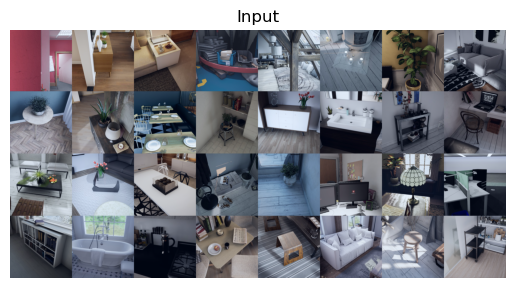

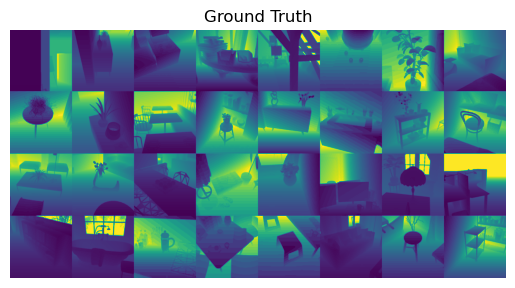

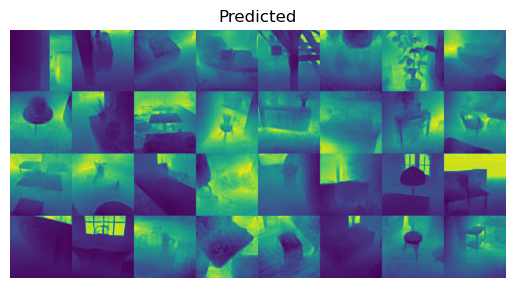

In [67]:
# Load model from disk
#model = Unet('resnet34', num_classes=1)
#model.load_state_dict(torch.load('model_n10_bs32_lr0.01.pkl'))
#model.eval() # set to evaluation mode


from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# Visualize validation sample
sample = next(iter(test_loader))
x = sample['image'].float().cuda()
y_pred, y = model(x), sample['depth']

# plt.figure(figsize=(4,8))
plt.imshow(make_grid(sample['image'], padding=0, normalize=True).permute((1, 2, 0)))
plt.axis('off')
plt.title("Input")
plt.show()

# plt.figure(figsize=(4,8))
plt.imshow(make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
plt.axis('off')
plt.title("Ground Truth")
plt.show()

# plt.figure(figsize=(4,8))
plt.imshow(make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
plt.axis('off')
plt.title("Predicted")
plt.show()

####  At this point, you can restart your notebook for part 2

# Part 2 : Semantic Segmentation

In this part of the project, you will reuse the model you created in the previous part to perform Semantic Segmentation - instead of assigning a real number to each
pixel, you will assign it a class.

The tasks are as following:
- Implement data prepareation: encoding and decoding of segmentation maps **[5 points]**
- Modify the UNet model that takes an RGB image and now outputs a _label map_ of _N_ classes **[15 points]**
- Define an approprate loss function. **[3 points]**
- Tune the model to achieve an mIOU of **0.45** or higher on the given validation set. **[10 points]**
- Visualization **[2 points]**

## Data Preparation [5 points]

We are going to use the [PASCAL VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/), which is a commonly used benchmark. In order to reduce the
computational requirements, we will be using [a variant](https://huggingface.co/datasets/shariqfarooq/cs323_densepred_seg256) that has a uniform and slightly lower resolution (256x256) than official. 

In [20]:
# Lets load the dataset first
from datasets import load_dataset

ds_voc = load_dataset("shariqfarooq/cs323_densepred_seg256")  # DO NOT change this

In [21]:
ds_voc

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 1464
    })
    val: Dataset({
        features: ['image', 'mask'],
        num_rows: 1449
    })
})

In [22]:
print(type(ds_voc['train'][0]['image']), type(ds_voc['train'][0]['mask']))

<class 'PIL.PngImagePlugin.PngImageFile'> <class 'PIL.PngImagePlugin.PngImageFile'>


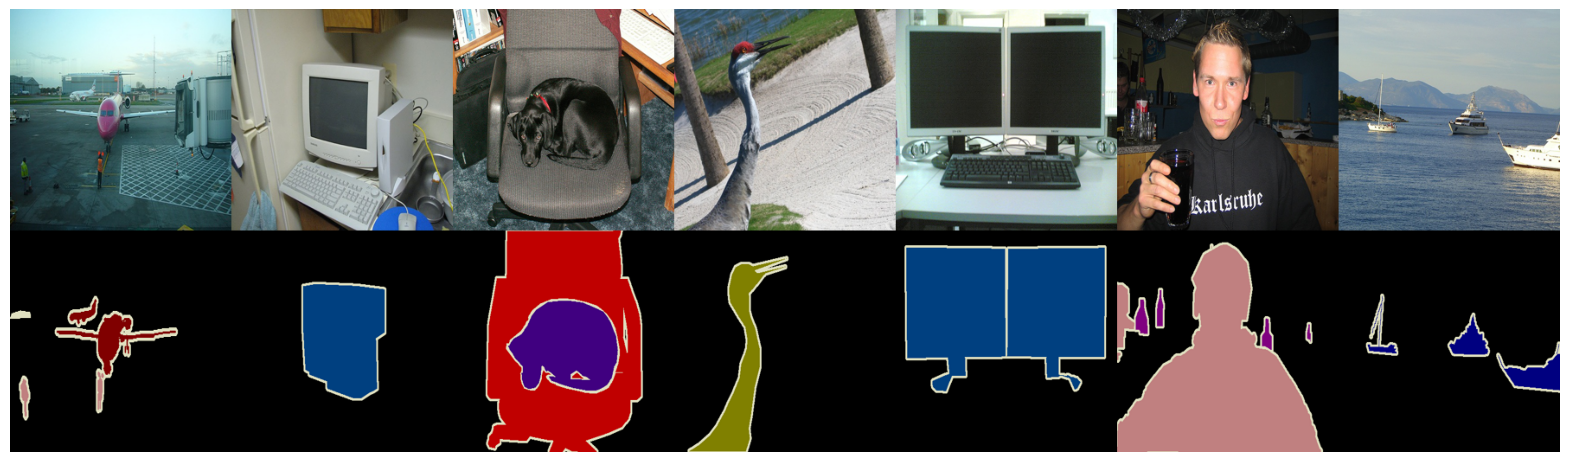

In [23]:
# Examine training data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def make_pil_grid(images, nrow=8):
    grid = Image.new('RGB', (images[0].width*nrow, images[0].height*((len(images)-1)//nrow+1)))
    for i, im in enumerate(images):
        grid.paste(im, (i%nrow*images[0].width, i//nrow*images[0].height))
    return grid
    
def show_example_data(dataset, split='train', num=7, nrow=7):
    ims = [dataset[split][i]['image'] for i in range(num)]
    masks = [dataset[split][i]['mask'] for i in range(num)]
    im_grid = make_pil_grid(ims, nrow)
    mask_grid = make_pil_grid(masks, nrow)

    grid = make_pil_grid([im_grid, mask_grid], 1)
    plt.figure(figsize=(20,20))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

show_example_data(ds_voc)

Now you have to implement the encoding and decoding of the data.

Make sure that the labels are in the range `0..N-1`, where
N is the number of classes - 21 in our case. You can have one special label for unknown regions.

We provide the map of RGB to label for convenience in `get_pascal_color_palette()`. The map should be read as this - if a pixel has color `[0, 0, 0]`, it has label 0. If the color is `[128, 0, 0]`, the label is 1 and so on.

You need to use the palette information to implement `encode_segmap` and `decode_segmap` functions

In [105]:

def get_pascal_color_palette():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0],
                       [128, 0, 0],
                       [0, 128, 0],
                       [128, 128, 0],
                       [0, 0, 128],
                       [128, 0, 128],
                       [0, 128, 128],
                       [128, 128, 128],
                       [64, 0, 0],
                       [192, 0, 0],
                       [64, 128, 0],
                       [192, 128, 0],
                       [64, 0, 128],
                       [192, 0, 128],
                       [64, 128, 128],
                       [192, 128, 128],
                       [0, 64, 0],
                       [128, 64, 0],
                       [0, 192, 0],
                       [128, 192, 0],
                       [0, 64, 128]])

def get_pascal_class_names():
    return ['Background',
            'Aeroplane',
            'Bicycle',
            'Bird',
            'Boat',
            'Bottle',
            'Bus',
            'Car',
            'Cat',
            'Chair',
            'Cow',
            'Diningtable',
            'Dog',
            'Horse',
            'Motorbike',
            'Person',
            'Pottedplant',
            'Sheep',
            'Sofa',
            'Train',
            'Tvmonitor']


def encode_segmap(mask, unk_label=255):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray or PIL.Image.Image): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """
    # TODO: Complete this function
    ##raise NotImplementedError("TODO: Implement this function")
    
    ## Convert the mask to a numpy array
    if type(mask) == 'torch.Tensor':
        mask = mask.numpy()
    mask = np.array(mask, dtype=int)
    mask[mask == unk_label] = 0
    
    if mask.shape[0]==3:
        mask = mask.transpose((1, 2, 0))
    
#     print(mask.shape, set(mask.flatten()))
#     for i in range(255):
#         print(mask[i, i, 0], mask[i, i, 1], mask[i, i, 2])
    
    ## create labels with dimensions (M, N)
    labels = np.zeros((mask.shape[0], mask.shape[1]), dtype=int)
    
    ## fill in the labels with indices of color in get_pascal_color_palette()
    for i, color in enumerate(get_pascal_color_palette()):
        idx = np.where(np.all(mask == color, axis=2))[:2] ##get the the image posions (idx)
        labels[idx] = i ## fill the labels with same index i
        #print(i, color, idx, labels[idx])
       
    labels = labels.astype(int)
    return labels
    

def decode_segmap(mask, unk_label=255):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3) ##Hui note: guess it should be [B, M, N, 3]
    """
    if type(mask) == 'torch.Tensor':
        mask = mask.numpy()
    mask = np.array(mask, dtype=int)
    mask[mask == unk_label] = 0
    
    # TODO: Complete this function
    #raise NotImplementedError("TODO: Implement this function")
    
    B,M,N = mask.shape
    imgs = np.zeros((B, M, N, 3), dtype=int)
    for b in range(B):
        for m in range(M):
            for n in range(N):
                idx = mask[b,m,n]
                imgs[b, m, n] = get_pascal_color_palette()[idx]

    imgs = torch.tensor(imgs.astype(int)) ## [B, M, N, 3]
    #print(imgs.shape) ##torch.Size([32, 256, 256, 3])
    return imgs

In [25]:
# TODO: Optionally add data augmentations to increase performance. 
# Note that any augmentation should act jointly on image and its mask label.  Look up `albumentations`.

# import albumentations as A ##Hui: add
# im_transforms = A.Compose([A.HorizontalFlip(p=0.5), ##Hui: add and change T to A
#                            A.ShiftScaleRotate(p=0.5),
#                            A.RandomBrightnessContrast(p=0.2),
#                            A.RGBShift(p=0.2)])

im_transforms = T.Compose([T.ToTensor(),
                           T.Normalize(mean=[0.4850, 0.4560, 0.4060], 
                                       std=[0.2290, 0.2240, 0.2250])])

def transform_voc(batch):
    batch['image'] = [im_transforms(i) for i in batch['image']]
    batch['mask'] = [torch.tensor(encode_segmap(m)) for m in batch['mask']] ##note before batch['mask'] is PIL, now, it's tensor
    return batch

ds_voc.set_transform(transform_voc)

In [26]:
# mask = ds_voc['train'][0]['mask'] 
# print(type(ds_voc['train'][0]['mask'] ))
# #plt.imshow(np.array(mask))
# #print(encode_segmap(mask))
# #print(image, mask)## 1 PIL.PngImagePlugin.PngImageFile image
# # print(im_tensor(mask).shape)
# # print(np.array(mask).shape, np.min(np.array(mask)), np.max(np.array(mask)))
# m = encode_segmap(mask)
# # print(m, m.shape, np.min(m), np.max(m))
# mask = torch.tensor(m)
# print(torch.min(mask), torch.max(mask))

You should implement a few more sanity checks - the range of data in the RGB part, the range of data in the label part, whether the dataset returns tensors,
whether the labels have the datatype `torch.long` etc.

In [27]:
# Perform sanity tests as required
# TODO: Add any sanity tests

image, mask = ds_voc['train'][0]['image'], ds_voc['train'][0]['mask']
print(image.shape)

r, g, b = image[0,:,:].numpy(), image[1,:,:].numpy(), image[2,:,:].numpy()
print('--- The range of data in the RGB part: ---')
print('red  :[min, max, mean]=',np.min(r), np.max(r), np.mean(r))
print('green:[min, max, mean]=',np.min(g), np.max(g), np.mean(g))
print('blue :[min, max, mean]=',np.min(b), np.max(b), np.mean(b))


if type(mask) == 'torch.Tensor':
    mask = mask.numpy()
mask = np.array(mask) ##shape=(255,255,3)
print('--- The range of data in the label (mask) part: ---')
print('all labels:', set(mask.flatten())) ##which shows image[0] includes Background + Areoplane + Person

torch.Size([3, 256, 256])
--- The range of data in the RGB part: ---
red  :[min, max, mean]= -2.117904 1.9064132 -0.37132305
green:[min, max, mean]= -1.9306722 2.4285715 0.33669648
blue :[min, max, mean]= -1.8044444 2.64 0.5811774
--- The range of data in the label (mask) part: ---
all labels: {0, 1, 15}


## Modifying Architecture and the loss [18 points]
You will have to some form of surgery on the network you constructed in Part 1.
You have to make sure you are initializing the weights with the depth model you trained above. And then doctor the model such that you attach a new _Segmentation Head_ as your final block.

1. The number of channels the last layer predicts must change to the number of classes in the dataset. The last activation may also change. 
2. The loss function must change to reflect the fact that we are now performing per-pixel classification. (What loss did you use for classification in Project 1?)
3. You might get a CUDA assert error. This means that you have a label higher than the number of channels in the _logits_. This is very common with semantic segmentation, where you might want to label some region unkown as it's label might be under doubt - for example near the edges of objects. Look up how to ignore a certain label with a classification loss.
4. Take care of input, label and logit sizes. We want predictions to be 256x256 as well, so you may need an upsampling layer in the _Segmentation Head_

Good luck!

In [28]:
### Hyperparameters
# TODO: Change these to your desired hyperparameters
epochs = 10 #100
batch_size = 32
learning_rate = 0.01 #1

#workers = 4 # The number of parallel processes used to read data. Increase this if you have more cores.
train_loader = DataLoader(ds_voc['train'], batch_size=batch_size, shuffle=True) #, num_workers=workers) ##Hui: will have bug, then comment
test_loader = DataLoader(ds_voc['val'], batch_size=batch_size) #, num_workers=workers)

In [29]:
# IMPORTANT
# You should use the exact same Unet class definition as in the previous section so
# TODO: Run the cell containing the Unet class definition in the previous section before proceeding

In [30]:
BACKBONE = "resnet34"  # TODO: Change this to your desired backbone

In [41]:
# Load the pretrained depth model
depth_pretrained_path = "./model_n10_bs32_lr0.01.pkl"  # TODO: Specify the path to your trained depth model
model = Unet(BACKBONE, num_classes=3) #Hui: changed from num_classes=1
# model = nn.DataParallel(model) ##Hui: show error
# model = model.cuda()
#model.load_state_dict(torch.load(depth_pretrained_path))

### Segmentation Head

In [42]:
class SegHead(nn.Module):
    """Segmentation Head.
    Args:
        in_channels (int): Number of input channels.
        out_classes (int): Number of output channels.
        The class contains three convolutional layers and two batch normalization layers 
        with ReLU activation functions in between.
        Upsample: scales the output tensor to a size of 256x256 using bilinear interpolation
    """
    # TODO: Implement a segmentation head here. Remember to complete the docstrings as well
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(256, out_channels, kernel_size=1)
        self.up = nn.Upsample(size=(256, 256), mode='bilinear')

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.conv3(x)
        x = self.up(x)
        return x


def change_classes(unet, target_classes=21):
    # TODO: Perform 'surgery' on the unet model to attach a segmentation head
    
    seg_head = SegHead(in_channels=3, out_channels=target_classes)
    
    # Attach the SegHead to the UNet model
    unet.decoder1.add_module('seg_head', seg_head)

    # Initialize the weights
    unet._initialize_weights()
    
    return unet

model = change_classes(model, target_classes=21) ##Hui: input 3 channels, output 21 channels
print(model)

Unet(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [85]:
import torch

def loss_fn(pred_y, y):
    #TODO: Change this to your desired loss function. 
    return torch.mean(y.sub(y_pred))  # Why wouldn't this work?
    
def loss_fn(output, y): ##Hui: change to cross_entropy loss for classification problem
    "https://discuss.pytorch.org/t/cross-entropy-loss-error-on-image-segmentation/60194/12"
    # output.shape==[32,21,256,256], y.shape==[32,256,256]
    #print( output.shape, y.shape)

    # Compute the cross-entropy loss
    loss = F.cross_entropy(output, y)

    return loss

## Training and Evaluation [10 points]
Tune the hyperparameters to get the maximum possible score on the PASCAL VOC challenge. 
And answer the following questions:
1. What is the relationship between the _size_ of the class and the IOU How would you quantify this relationship?
2. What is the relationship between the number of instances and the IOU? how many times a class exists in an image vs the IOU?
3. Which weights can you not transfer from the depth model?

In [86]:
from tqdm.auto import tqdm
import gc
import os

In [87]:
from utils import Metrics

In [88]:
model = model.cuda()

In [89]:
run_id = f'seg_model_n{epochs}_bs{batch_size}_lr{learning_rate}'; print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

# TODO: Experiment with different optimizers and learning rate schedulers
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=learning_rate*0.1, ##Hui: *0.1 
                                                steps_per_epoch=len(train_loader), epochs=epochs)

metrics = Metrics(len(get_pascal_class_names()), get_pascal_class_names())


ITER_PER_EPOCH = len(train_loader)
TOTAL_STEPS = ITER_PER_EPOCH * epochs

@torch.no_grad()
def validate(model, valid_loader):
    model.eval()
    metrics.reset()
    for i, (sample) in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validating'):
        x, y = sample['image'].float().cuda(), sample['mask'].numpy()
        y_pred = model(x)
        ##print(sample['image'].float().shape, y.shape, y_pred.shape)
        ## Hui: x.shape==[32, 3, 256, 256], y.shape==[32, 256, 256], y_pred.shape== [32, 21, 256, 256]
        y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y, y_pred.detach().cpu().numpy())
    print('\nValidation stats ', metrics.get_table())


validate(model, test_loader)
pbar = tqdm(total=TOTAL_STEPS, desc='Training')
for epoch in range(epochs):
    model.train()

    N = len(train_loader)

    for i, (sample) in enumerate(train_loader):
        # Load a batch and send it to GPU
        x = sample['image'].float().cuda() ## Hui: shape=(3, 256, 256)
        y = sample['mask'].long().cuda() ## Hui: shape=(256, 256) int
        ## Hui: x.shape==[32, 3, 256, 256], y.shape==[32, 256, 256]

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x) ## Hui: shape=(32, 21, 256, 256)
        
        # Compute and print loss.
        loss = loss_fn(y_pred, y) ##Hui: defined loss function by cross_entropy

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        scheduler.step() # TODO: location of this call might change depending on your choice of scheduler.
        pbar.update(1)
        pbar.set_postfix({'epoch': f"{epoch+1}/{epochs}", 'loss': loss.item(), 'epoch%': "{0:.1f}%".format(100*(i+1)/N)})

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    validate(model, test_loader)


# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training seg_model_n10_bs32_lr0.01


Validating: 100%|██████████| 46/46 [00:59<00:00,  1.28s/it]



Validation stats                    IoU       F1      Prec    recall       Acc
Background   0.012200  0.02410  0.792300  0.012200  0.235400
Aeroplane    0.000300  0.00060  0.003300  0.000300  0.992500
Bicycle      0.000200  0.00030  0.001700  0.000200  0.998400
Bird         0.007400  0.01470  0.007500  0.293000  0.710500
Boat         0.004800  0.00960  0.004900  0.369800  0.655400
Bottle       0.006600  0.01300  0.007300  0.058900  0.938200
Bus          0.000000  0.00000  0.000000  0.000000  0.984100
Car          0.000100  0.00020  0.002600  0.000100  0.986300
Cat          0.015200  0.02990  0.020600  0.054500  0.928800
Chair        0.001200  0.00230  0.003800  0.001700  0.990300
Cow          0.000300  0.00050  0.008900  0.000300  0.989400
Diningtable  0.000000  0.00000  0.045500  0.000000  0.989700
Dog          0.000400  0.00080  0.005000  0.000500  0.980300
Horse        0.000000  0.00000  0.000000  0.000000  0.990800
Motorbike    0.007500  0.01480  0.011300  0.021600  0.975200
Perso

Training:   0%|          | 0/460 [2:56:24<?, ?it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   0%|          | 2/460 [00:02<11:10,  1.46s/it, epoch=1/10, loss=2.95, epoch%=2.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   1%|          | 3/460 [00:04<10:46,  1.42s/it, epoch=1/10, loss=2.92, epoch%=4.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   1%|          | 4/460 [00:05<10:32,  1.39s/it, epoch=1/10, loss=2.84, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   1%|          | 5/460 [00:07<10:24,  1.37s/it, epoch=1/10, loss=2.84, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   1%|▏         | 6/460 [00:08<10:17,  1.36s/it, epoch=1/10, loss=2.76, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   2%|▏         | 7/460 [00:09<10:12,  1.35s/it, epoch=1/10, loss=2.76, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   2%|▏         | 8/460 [00:11<10:08,  1.35s/it, epoch=1/10, loss=2.75, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   2%|▏         | 9/460 [00:12<10:06,  1.35s/it, epoch=1/10, loss=2.66, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   2%|▏         | 10/460 [00:13<10:04,  1.34s/it, epoch=1/10, loss=2.6, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   2%|▏         | 11/460 [00:15<10:01,  1.34s/it, epoch=1/10, loss=2.56, epoch%=21.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   3%|▎         | 12/460 [00:16<10:01,  1.34s/it, epoch=1/10, loss=2.52, epoch%=23.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   3%|▎         | 13/460 [00:17<10:02,  1.35s/it, epoch=1/10, loss=2.39, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   3%|▎         | 14/460 [00:19<10:00,  1.35s/it, epoch=1/10, loss=2.39, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   3%|▎         | 15/460 [00:20<10:00,  1.35s/it, epoch=1/10, loss=2.26, epoch%=30.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   3%|▎         | 16/460 [00:21<10:01,  1.36s/it, epoch=1/10, loss=2.16, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   4%|▎         | 17/460 [00:23<09:59,  1.35s/it, epoch=1/10, loss=2.19, epoch%=34.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   4%|▍         | 18/460 [00:24<09:59,  1.36s/it, epoch=1/10, loss=2.06, epoch%=37.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   4%|▍         | 19/460 [00:25<09:57,  1.35s/it, epoch=1/10, loss=1.98, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   4%|▍         | 20/460 [00:27<09:55,  1.35s/it, epoch=1/10, loss=2.06, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   5%|▍         | 21/460 [00:28<09:54,  1.35s/it, epoch=1/10, loss=1.87, epoch%=43.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   5%|▍         | 22/460 [00:29<09:53,  1.36s/it, epoch=1/10, loss=1.76, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   5%|▌         | 23/460 [00:31<09:47,  1.34s/it, epoch=1/10, loss=1.71, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   5%|▌         | 24/460 [00:32<09:46,  1.35s/it, epoch=1/10, loss=1.66, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   5%|▌         | 25/460 [00:33<09:46,  1.35s/it, epoch=1/10, loss=1.45, epoch%=52.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   6%|▌         | 26/460 [00:35<09:49,  1.36s/it, epoch=1/10, loss=1.63, epoch%=54.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   6%|▌         | 27/460 [00:36<09:48,  1.36s/it, epoch=1/10, loss=1.77, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   6%|▌         | 28/460 [00:38<09:46,  1.36s/it, epoch=1/10, loss=1.35, epoch%=58.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   6%|▋         | 29/460 [00:39<09:42,  1.35s/it, epoch=1/10, loss=1.53, epoch%=60.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   7%|▋         | 30/460 [00:40<09:42,  1.35s/it, epoch=1/10, loss=1.3, epoch%=63.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   7%|▋         | 31/460 [00:42<09:39,  1.35s/it, epoch=1/10, loss=1.33, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   7%|▋         | 32/460 [00:43<09:39,  1.35s/it, epoch=1/10, loss=1.34, epoch%=67.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   7%|▋         | 33/460 [00:44<09:36,  1.35s/it, epoch=1/10, loss=1.43, epoch%=69.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   7%|▋         | 34/460 [00:46<09:36,  1.35s/it, epoch=1/10, loss=1.48, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   8%|▊         | 35/460 [00:47<09:33,  1.35s/it, epoch=1/10, loss=1.33, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   8%|▊         | 36/460 [00:48<09:31,  1.35s/it, epoch=1/10, loss=1.33, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   8%|▊         | 37/460 [00:50<09:28,  1.34s/it, epoch=1/10, loss=1.27, epoch%=78.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   8%|▊         | 38/460 [00:51<09:25,  1.34s/it, epoch=1/10, loss=1.39, epoch%=80.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   8%|▊         | 39/460 [00:52<09:24,  1.34s/it, epoch=1/10, loss=1.44, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   9%|▊         | 40/460 [00:54<09:25,  1.35s/it, epoch=1/10, loss=1.17, epoch%=84.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   9%|▉         | 41/460 [00:55<09:22,  1.34s/it, epoch=1/10, loss=1.16, epoch%=87.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   9%|▉         | 42/460 [00:56<09:17,  1.33s/it, epoch=1/10, loss=1.41, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:   9%|▉         | 43/460 [00:58<09:18,  1.34s/it, epoch=1/10, loss=1.35, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  10%|▉         | 44/460 [00:59<09:18,  1.34s/it, epoch=1/10, loss=1.37, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  10%|▉         | 45/460 [01:00<09:14,  1.34s/it, epoch=1/10, loss=1.21, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  10%|█         | 46/460 [01:02<08:53,  1.29s/it, epoch=1/10, loss=1.32, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:58<00:00,  1.28s/it]



Validation stats                    IoU        F1      Prec    recall       Acc
Background   0.769800  0.869800  0.772400  0.995500  0.770200
Aeroplane    0.000000  0.000000  0.000000  0.000000  0.993200
Bicycle      0.000000  0.000000  0.000000  0.000000  0.998600
Bird         0.000000  0.000000  0.000000  0.000000  0.992600
Boat         0.000000  0.000000  0.000000  0.000000  0.995500
Bottle       0.000000  0.000000  0.000000  0.000000  0.993100
Bus          0.000000  0.000000  0.000000  0.000000  0.984100
Car          0.000100  0.000200  0.019700  0.000100  0.986700
Cat          0.000000  0.000000  0.000000  0.000000  0.979900
Chair        0.000000  0.000000  0.000000  0.000000  0.993300
Cow          0.000000  0.000000  0.000000  0.000000  0.989700
Diningtable  0.000000  0.000000  0.000000  0.000000  0.989700
Dog          0.000000  0.000000  0.000000  0.000000  0.982000
Horse        0.000000  0.000000  0.000000  0.000000  0.990800
Motorbike    0.000000  0.000100  0.009700  0.000000

Training:  10%|█         | 47/460 [02:02<2:10:39, 18.98s/it, epoch=2/10, loss=1.19, epoch%=2.2%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  10%|█         | 48/460 [02:03<1:34:26, 13.75s/it, epoch=2/10, loss=1.19, epoch%=2.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  11%|█         | 49/460 [02:05<1:08:45, 10.04s/it, epoch=2/10, loss=1.15, epoch%=4.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  11%|█         | 50/460 [02:06<50:47,  7.43s/it, epoch=2/10, loss=1.21, epoch%=6.5%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  11%|█         | 51/460 [02:07<38:16,  5.61s/it, epoch=2/10, loss=1.17, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  11%|█▏        | 52/460 [02:09<29:32,  4.34s/it, epoch=2/10, loss=1.22, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  12%|█▏        | 53/460 [02:10<23:21,  3.44s/it, epoch=2/10, loss=1.02, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  12%|█▏        | 54/460 [02:12<19:06,  2.82s/it, epoch=2/10, loss=1.17, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  12%|█▏        | 55/460 [02:13<16:07,  2.39s/it, epoch=2/10, loss=1.08, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  12%|█▏        | 56/460 [02:14<14:01,  2.08s/it, epoch=2/10, loss=1.24, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  12%|█▏        | 57/460 [02:16<12:32,  1.87s/it, epoch=2/10, loss=1.43, epoch%=21.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  13%|█▎        | 58/460 [02:17<11:28,  1.71s/it, epoch=2/10, loss=1.16, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  13%|█▎        | 59/460 [02:18<10:45,  1.61s/it, epoch=2/10, loss=1.16, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  13%|█▎        | 60/460 [02:20<10:13,  1.53s/it, epoch=2/10, loss=1.06, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  13%|█▎        | 61/460 [02:21<09:48,  1.48s/it, epoch=2/10, loss=1.07, epoch%=30.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  13%|█▎        | 62/460 [02:22<09:36,  1.45s/it, epoch=2/10, loss=0.892, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  14%|█▎        | 63/460 [02:24<09:26,  1.43s/it, epoch=2/10, loss=1.16, epoch%=34.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  14%|█▍        | 64/460 [02:25<09:17,  1.41s/it, epoch=2/10, loss=1.04, epoch%=37.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  14%|█▍        | 65/460 [02:27<09:12,  1.40s/it, epoch=2/10, loss=1.13, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  14%|█▍        | 66/460 [02:28<09:07,  1.39s/it, epoch=2/10, loss=1.19, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  15%|█▍        | 67/460 [02:29<09:02,  1.38s/it, epoch=2/10, loss=1.11, epoch%=43.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  15%|█▍        | 68/460 [02:31<09:01,  1.38s/it, epoch=2/10, loss=1.14, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  15%|█▌        | 69/460 [02:32<08:57,  1.38s/it, epoch=2/10, loss=1.3, epoch%=47.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  15%|█▌        | 70/460 [02:33<08:56,  1.38s/it, epoch=2/10, loss=1.3, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  15%|█▌        | 71/460 [02:35<08:54,  1.37s/it, epoch=2/10, loss=0.874, epoch%=52.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  16%|█▌        | 72/460 [02:36<08:53,  1.37s/it, epoch=2/10, loss=1.24, epoch%=54.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  16%|█▌        | 73/460 [02:38<08:52,  1.38s/it, epoch=2/10, loss=1.2, epoch%=56.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  16%|█▌        | 74/460 [02:39<08:51,  1.38s/it, epoch=2/10, loss=1.11, epoch%=58.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  16%|█▋        | 75/460 [02:40<08:48,  1.37s/it, epoch=2/10, loss=1.5, epoch%=60.9%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  17%|█▋        | 76/460 [02:42<08:46,  1.37s/it, epoch=2/10, loss=0.961, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  17%|█▋        | 77/460 [02:43<08:46,  1.37s/it, epoch=2/10, loss=1.36, epoch%=65.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  17%|█▋        | 78/460 [02:44<08:43,  1.37s/it, epoch=2/10, loss=1, epoch%=67.4%]   

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  17%|█▋        | 79/460 [02:46<08:39,  1.36s/it, epoch=2/10, loss=1.17, epoch%=69.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  17%|█▋        | 80/460 [02:47<08:37,  1.36s/it, epoch=2/10, loss=1.28, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  18%|█▊        | 81/460 [02:48<08:35,  1.36s/it, epoch=2/10, loss=1.29, epoch%=73.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  18%|█▊        | 82/460 [02:50<08:34,  1.36s/it, epoch=2/10, loss=1.05, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  18%|█▊        | 83/460 [02:51<08:33,  1.36s/it, epoch=2/10, loss=1.17, epoch%=78.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  18%|█▊        | 84/460 [02:53<08:31,  1.36s/it, epoch=2/10, loss=1.33, epoch%=80.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  18%|█▊        | 85/460 [02:54<08:36,  1.38s/it, epoch=2/10, loss=0.985, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  19%|█▊        | 86/460 [02:55<08:32,  1.37s/it, epoch=2/10, loss=1.12, epoch%=84.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  19%|█▉        | 87/460 [02:57<08:32,  1.37s/it, epoch=2/10, loss=1.29, epoch%=87.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  19%|█▉        | 88/460 [02:58<08:32,  1.38s/it, epoch=2/10, loss=1.11, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  19%|█▉        | 89/460 [02:59<08:27,  1.37s/it, epoch=2/10, loss=1.17, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  20%|█▉        | 90/460 [03:01<08:24,  1.36s/it, epoch=2/10, loss=0.813, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  20%|█▉        | 91/460 [03:02<08:27,  1.38s/it, epoch=2/10, loss=0.959, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  20%|██        | 92/460 [03:03<07:52,  1.28s/it, epoch=2/10, loss=1.21, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:59<00:00,  1.30s/it]



Validation stats                   IoU        F1      Prec    recall       Acc
Background   0.74440  0.853400  0.793000  0.924000  0.755300
Aeroplane    0.00000  0.000000  0.000000  0.000000  0.993200
Bicycle      0.00000  0.000000  0.000000  0.000000  0.998600
Bird         0.00000  0.000000  0.000000  0.000000  0.992600
Boat         0.00000  0.000000  0.000000  0.000000  0.995500
Bottle       0.00000  0.000000  0.000000  0.000000  0.993100
Bus          0.00000  0.000000  0.000000  0.000000  0.984100
Car          0.03260  0.063200  0.042800  0.120500  0.952700
Cat          0.00060  0.001100  0.017600  0.000600  0.979200
Chair        0.00000  0.000000  0.000000  0.000000  0.993300
Cow          0.00000  0.000000  0.017000  0.000000  0.989700
Diningtable  0.00000  0.000000  0.000000  0.000000  0.989700
Dog          0.00000  0.000000  0.000000  0.000000  0.982000
Horse        0.00000  0.000000  0.000000  0.000000  0.990800
Motorbike    0.03520  0.067900  0.043100  0.160200  0.962000
Perso

Training:  20%|██        | 93/460 [04:05<1:57:50, 19.27s/it, epoch=2/10, loss=1.21, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  20%|██        | 94/460 [04:06<1:25:01, 13.94s/it, epoch=3/10, loss=1.12, epoch%=2.2%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  21%|██        | 95/460 [04:07<1:01:47, 10.16s/it, epoch=3/10, loss=1.03, epoch%=4.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  21%|██        | 96/460 [04:09<45:35,  7.51s/it, epoch=3/10, loss=1.2, epoch%=6.5%]   

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  21%|██        | 97/460 [04:10<34:18,  5.67s/it, epoch=3/10, loss=1.2, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  21%|██▏       | 98/460 [04:11<26:21,  4.37s/it, epoch=3/10, loss=1.02, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  22%|██▏       | 99/460 [04:13<20:50,  3.46s/it, epoch=3/10, loss=1.14, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  22%|██▏       | 100/460 [04:14<16:59,  2.83s/it, epoch=3/10, loss=1.34, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  22%|██▏       | 101/460 [04:15<14:16,  2.38s/it, epoch=3/10, loss=0.861, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  22%|██▏       | 102/460 [04:17<12:20,  2.07s/it, epoch=3/10, loss=1.07, epoch%=19.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  22%|██▏       | 103/460 [04:18<11:01,  1.85s/it, epoch=3/10, loss=0.903, epoch%=21.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  23%|██▎       | 104/460 [04:19<10:06,  1.70s/it, epoch=3/10, loss=1.26, epoch%=23.9%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  23%|██▎       | 105/460 [04:21<09:26,  1.60s/it, epoch=3/10, loss=1.17, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  23%|██▎       | 106/460 [04:22<09:00,  1.53s/it, epoch=3/10, loss=1.01, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  23%|██▎       | 107/460 [04:24<08:39,  1.47s/it, epoch=3/10, loss=1.07, epoch%=30.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  23%|██▎       | 108/460 [04:25<08:25,  1.44s/it, epoch=3/10, loss=1.04, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  24%|██▎       | 109/460 [04:26<08:14,  1.41s/it, epoch=3/10, loss=1.13, epoch%=34.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  24%|██▍       | 110/460 [04:28<08:06,  1.39s/it, epoch=3/10, loss=0.969, epoch%=37.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  24%|██▍       | 111/460 [04:29<08:00,  1.38s/it, epoch=3/10, loss=1.15, epoch%=39.1%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  24%|██▍       | 112/460 [04:30<07:56,  1.37s/it, epoch=3/10, loss=1.08, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  25%|██▍       | 113/460 [04:32<07:54,  1.37s/it, epoch=3/10, loss=1.1, epoch%=43.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  25%|██▍       | 114/460 [04:33<07:48,  1.35s/it, epoch=3/10, loss=1.28, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  25%|██▌       | 115/460 [04:34<07:44,  1.35s/it, epoch=3/10, loss=0.931, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  25%|██▌       | 116/460 [04:36<07:41,  1.34s/it, epoch=3/10, loss=0.982, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  25%|██▌       | 117/460 [04:37<07:41,  1.35s/it, epoch=3/10, loss=1.04, epoch%=52.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  26%|██▌       | 118/460 [04:38<07:40,  1.35s/it, epoch=3/10, loss=0.93, epoch%=54.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  26%|██▌       | 119/460 [04:40<07:39,  1.35s/it, epoch=3/10, loss=1.5, epoch%=56.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  26%|██▌       | 120/460 [04:41<07:37,  1.34s/it, epoch=3/10, loss=1.29, epoch%=58.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  26%|██▋       | 121/460 [04:42<07:36,  1.35s/it, epoch=3/10, loss=1.06, epoch%=60.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  27%|██▋       | 122/460 [04:44<07:32,  1.34s/it, epoch=3/10, loss=1.22, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  27%|██▋       | 123/460 [04:45<07:32,  1.34s/it, epoch=3/10, loss=0.922, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  27%|██▋       | 124/460 [04:46<07:31,  1.35s/it, epoch=3/10, loss=1.08, epoch%=67.4%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  27%|██▋       | 125/460 [04:48<07:33,  1.35s/it, epoch=3/10, loss=1.01, epoch%=69.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  27%|██▋       | 126/460 [04:49<07:32,  1.35s/it, epoch=3/10, loss=1.27, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  28%|██▊       | 127/460 [04:50<07:30,  1.35s/it, epoch=3/10, loss=1.16, epoch%=73.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  28%|██▊       | 128/460 [04:52<07:26,  1.35s/it, epoch=3/10, loss=1.26, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  28%|██▊       | 129/460 [04:53<07:25,  1.35s/it, epoch=3/10, loss=1.08, epoch%=78.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  28%|██▊       | 130/460 [04:55<07:26,  1.35s/it, epoch=3/10, loss=1.05, epoch%=80.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  28%|██▊       | 131/460 [04:56<07:24,  1.35s/it, epoch=3/10, loss=1.37, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  29%|██▊       | 132/460 [04:57<07:22,  1.35s/it, epoch=3/10, loss=1.17, epoch%=84.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  29%|██▉       | 133/460 [04:59<07:22,  1.35s/it, epoch=3/10, loss=1.01, epoch%=87.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  29%|██▉       | 134/460 [05:00<07:19,  1.35s/it, epoch=3/10, loss=1.1, epoch%=89.1%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  29%|██▉       | 135/460 [05:01<07:17,  1.35s/it, epoch=3/10, loss=0.946, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  30%|██▉       | 136/460 [05:03<07:14,  1.34s/it, epoch=3/10, loss=1.19, epoch%=93.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  30%|██▉       | 137/460 [05:04<07:14,  1.34s/it, epoch=3/10, loss=1.05, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  30%|███       | 138/460 [05:05<06:46,  1.26s/it, epoch=3/10, loss=1.03, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:58<00:00,  1.27s/it]



Validation stats                    IoU        F1      Prec   recall       Acc
Background   0.754700  0.860200  0.772300  0.97080  0.756600
Aeroplane    0.000000  0.000000  0.000000  0.00000  0.993200
Bicycle      0.000000  0.000000  0.000000  0.00000  0.998600
Bird         0.000000  0.000000  0.000000  0.00000  0.992600
Boat         0.000000  0.000000  0.000300  0.00000  0.995400
Bottle       0.000000  0.000000  0.000000  0.00000  0.993100
Bus          0.000000  0.000000  0.000000  0.00000  0.984100
Car          0.000000  0.000000  0.000000  0.00000  0.986800
Cat          0.000000  0.000000  0.002100  0.00000  0.979800
Chair        0.000000  0.000000  0.004700  0.00000  0.993200
Cow          0.000000  0.000000  0.000000  0.00000  0.989700
Diningtable  0.000000  0.000000  0.000000  0.00000  0.989700
Dog          0.000000  0.000000  0.000000  0.00000  0.982000
Horse        0.000000  0.000000  0.000000  0.00000  0.990800
Motorbike    0.001700  0.003300  0.019900  0.00180  0.990600
Perso

Training:  30%|███       | 139/460 [06:05<1:41:09, 18.91s/it, epoch=3/10, loss=1.03, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  30%|███       | 140/460 [06:07<1:12:57, 13.68s/it, epoch=4/10, loss=1.19, epoch%=2.2%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  31%|███       | 141/460 [06:08<53:03,  9.98s/it, epoch=4/10, loss=0.982, epoch%=6.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  31%|███       | 142/460 [06:09<39:05,  7.38s/it, epoch=4/10, loss=0.982, epoch%=6.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  31%|███       | 143/460 [06:11<29:27,  5.58s/it, epoch=4/10, loss=1.14, epoch%=8.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  31%|███▏      | 144/460 [06:12<22:42,  4.31s/it, epoch=4/10, loss=1.06, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  32%|███▏      | 145/460 [06:13<18:00,  3.43s/it, epoch=4/10, loss=1.16, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  32%|███▏      | 146/460 [06:15<14:38,  2.80s/it, epoch=4/10, loss=1.21, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  32%|███▏      | 147/460 [06:16<12:19,  2.36s/it, epoch=4/10, loss=0.963, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  32%|███▏      | 148/460 [06:17<10:42,  2.06s/it, epoch=4/10, loss=1.01, epoch%=19.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  32%|███▏      | 149/460 [06:19<09:34,  1.85s/it, epoch=4/10, loss=1.19, epoch%=21.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  33%|███▎      | 150/460 [06:20<08:46,  1.70s/it, epoch=4/10, loss=1.08, epoch%=23.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  33%|███▎      | 151/460 [06:21<08:11,  1.59s/it, epoch=4/10, loss=1.04, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  33%|███▎      | 152/460 [06:23<07:47,  1.52s/it, epoch=4/10, loss=1.29, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  33%|███▎      | 153/460 [06:24<07:30,  1.47s/it, epoch=4/10, loss=1.04, epoch%=30.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  33%|███▎      | 154/460 [06:25<07:17,  1.43s/it, epoch=4/10, loss=1.01, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  34%|███▎      | 155/460 [06:27<07:08,  1.41s/it, epoch=4/10, loss=1.04, epoch%=34.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  34%|███▍      | 156/460 [06:28<07:02,  1.39s/it, epoch=4/10, loss=1.11, epoch%=37.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  34%|███▍      | 157/460 [06:29<06:57,  1.38s/it, epoch=4/10, loss=1.15, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  34%|███▍      | 158/460 [06:31<06:53,  1.37s/it, epoch=4/10, loss=1.11, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  35%|███▍      | 159/460 [06:32<06:50,  1.36s/it, epoch=4/10, loss=1.07, epoch%=43.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  35%|███▍      | 160/460 [06:34<06:47,  1.36s/it, epoch=4/10, loss=1.15, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  35%|███▌      | 161/460 [06:35<06:45,  1.36s/it, epoch=4/10, loss=1.15, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  35%|███▌      | 162/460 [06:36<06:43,  1.35s/it, epoch=4/10, loss=1.09, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  35%|███▌      | 163/460 [06:38<06:41,  1.35s/it, epoch=4/10, loss=1.23, epoch%=52.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  36%|███▌      | 164/460 [06:39<06:40,  1.35s/it, epoch=4/10, loss=1.13, epoch%=54.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  36%|███▌      | 165/460 [06:40<06:37,  1.35s/it, epoch=4/10, loss=0.943, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  36%|███▌      | 166/460 [06:42<06:36,  1.35s/it, epoch=4/10, loss=1.07, epoch%=58.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  36%|███▋      | 167/460 [06:43<06:36,  1.35s/it, epoch=4/10, loss=1.19, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  37%|███▋      | 168/460 [06:44<06:33,  1.35s/it, epoch=4/10, loss=1.19, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  37%|███▋      | 169/460 [06:46<06:32,  1.35s/it, epoch=4/10, loss=1.03, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  37%|███▋      | 170/460 [06:47<06:29,  1.34s/it, epoch=4/10, loss=1.04, epoch%=67.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  37%|███▋      | 171/460 [06:48<06:29,  1.35s/it, epoch=4/10, loss=1.07, epoch%=69.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  37%|███▋      | 172/460 [06:50<06:27,  1.35s/it, epoch=4/10, loss=0.856, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  38%|███▊      | 173/460 [06:51<06:28,  1.35s/it, epoch=4/10, loss=0.965, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  38%|███▊      | 174/460 [06:52<06:25,  1.35s/it, epoch=4/10, loss=0.965, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  38%|███▊      | 175/460 [06:54<06:25,  1.35s/it, epoch=4/10, loss=1.18, epoch%=78.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  38%|███▊      | 176/460 [06:55<06:23,  1.35s/it, epoch=4/10, loss=0.997, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  38%|███▊      | 177/460 [06:56<06:21,  1.35s/it, epoch=4/10, loss=0.997, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  39%|███▊      | 178/460 [06:58<06:20,  1.35s/it, epoch=4/10, loss=1.16, epoch%=84.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  39%|███▉      | 179/460 [06:59<06:18,  1.35s/it, epoch=4/10, loss=1.2, epoch%=87.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  39%|███▉      | 180/460 [07:01<06:17,  1.35s/it, epoch=4/10, loss=0.906, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  39%|███▉      | 181/460 [07:02<06:16,  1.35s/it, epoch=4/10, loss=0.941, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  40%|███▉      | 182/460 [07:03<06:15,  1.35s/it, epoch=4/10, loss=1.13, epoch%=93.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  40%|███▉      | 183/460 [07:05<06:14,  1.35s/it, epoch=4/10, loss=0.911, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  40%|████      | 184/460 [07:06<05:50,  1.27s/it, epoch=4/10, loss=1.06, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:58<00:00,  1.28s/it]



Validation stats                    IoU        F1      Prec    recall       Acc
Background   0.762300  0.865100  0.779900  0.971300  0.766400
Aeroplane    0.000000  0.000000  0.000000  0.000000  0.993200
Bicycle      0.000500  0.001100  0.010600  0.000600  0.998500
Bird         0.000000  0.000000  0.000000  0.000000  0.992600
Boat         0.000000  0.000000  0.000000  0.000000  0.995500
Bottle       0.000000  0.000000  0.000000  0.000000  0.993100
Bus          0.000000  0.000000  0.000000  0.000000  0.984100
Car          0.000000  0.000000  0.000000  0.000000  0.986800
Cat          0.000000  0.000000  0.000000  0.000000  0.979900
Chair        0.000000  0.000000  0.000000  0.000000  0.993300
Cow          0.000000  0.000000  0.000000  0.000000  0.989700
Diningtable  0.000000  0.000000  0.000000  0.000000  0.989700
Dog          0.000000  0.000000  0.000000  0.000000  0.982000
Horse        0.000000  0.000000  0.000000  0.000000  0.990800
Motorbike    0.075700  0.140700  0.087300  0.362600

Training:  40%|████      | 185/460 [08:06<1:27:02, 18.99s/it, epoch=4/10, loss=1.06, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  40%|████      | 186/460 [08:07<1:02:44, 13.74s/it, epoch=5/10, loss=0.999, epoch%=2.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  41%|████      | 187/460 [08:09<45:35, 10.02s/it, epoch=5/10, loss=1.2, epoch%=4.3%]    

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  41%|████      | 188/460 [08:10<33:38,  7.42s/it, epoch=5/10, loss=1.08, epoch%=6.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  41%|████      | 189/460 [08:12<25:18,  5.60s/it, epoch=5/10, loss=1.07, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  41%|████▏     | 190/460 [08:13<19:28,  4.33s/it, epoch=5/10, loss=0.913, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  42%|████▏     | 191/460 [08:14<15:25,  3.44s/it, epoch=5/10, loss=1.09, epoch%=13.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  42%|████▏     | 192/460 [08:16<12:37,  2.83s/it, epoch=5/10, loss=0.845, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  42%|████▏     | 193/460 [08:17<10:38,  2.39s/it, epoch=5/10, loss=0.925, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  42%|████▏     | 194/460 [08:18<09:13,  2.08s/it, epoch=5/10, loss=0.993, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  42%|████▏     | 195/460 [08:20<08:14,  1.86s/it, epoch=5/10, loss=1.04, epoch%=21.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  43%|████▎     | 196/460 [08:21<07:31,  1.71s/it, epoch=5/10, loss=1.02, epoch%=23.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  43%|████▎     | 197/460 [08:23<07:02,  1.61s/it, epoch=5/10, loss=1.18, epoch%=28.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  43%|████▎     | 198/460 [08:24<06:41,  1.53s/it, epoch=5/10, loss=1.18, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  43%|████▎     | 199/460 [08:25<06:25,  1.48s/it, epoch=5/10, loss=0.971, epoch%=30.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  43%|████▎     | 200/460 [08:27<06:14,  1.44s/it, epoch=5/10, loss=1.21, epoch%=32.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  44%|████▎     | 201/460 [08:28<06:09,  1.43s/it, epoch=5/10, loss=1.11, epoch%=34.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  44%|████▍     | 202/460 [08:29<06:04,  1.41s/it, epoch=5/10, loss=1.37, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  44%|████▍     | 203/460 [08:31<06:01,  1.40s/it, epoch=5/10, loss=1.37, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  44%|████▍     | 204/460 [08:32<05:55,  1.39s/it, epoch=5/10, loss=0.984, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  45%|████▍     | 205/460 [08:33<05:53,  1.39s/it, epoch=5/10, loss=1.02, epoch%=43.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  45%|████▍     | 206/460 [08:35<05:48,  1.37s/it, epoch=5/10, loss=1.11, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  45%|████▌     | 207/460 [08:36<05:45,  1.36s/it, epoch=5/10, loss=0.854, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  45%|████▌     | 208/460 [08:37<05:43,  1.36s/it, epoch=5/10, loss=1.19, epoch%=50.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  45%|████▌     | 209/460 [08:39<05:41,  1.36s/it, epoch=5/10, loss=1.1, epoch%=52.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  46%|████▌     | 210/460 [08:40<05:37,  1.35s/it, epoch=5/10, loss=1.22, epoch%=54.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  46%|████▌     | 211/460 [08:41<05:36,  1.35s/it, epoch=5/10, loss=0.772, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  46%|████▌     | 212/460 [08:43<05:35,  1.35s/it, epoch=5/10, loss=1.32, epoch%=58.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  46%|████▋     | 213/460 [08:44<05:33,  1.35s/it, epoch=5/10, loss=1.16, epoch%=60.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  47%|████▋     | 214/460 [08:46<05:31,  1.35s/it, epoch=5/10, loss=0.78, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  47%|████▋     | 215/460 [08:47<05:30,  1.35s/it, epoch=5/10, loss=1.09, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  47%|████▋     | 216/460 [08:48<05:29,  1.35s/it, epoch=5/10, loss=1.11, epoch%=67.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  47%|████▋     | 217/460 [08:50<05:28,  1.35s/it, epoch=5/10, loss=1.12, epoch%=69.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  47%|████▋     | 218/460 [08:51<05:29,  1.36s/it, epoch=5/10, loss=1.33, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  48%|████▊     | 219/460 [08:52<05:29,  1.37s/it, epoch=5/10, loss=0.893, epoch%=73.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  48%|████▊     | 220/460 [08:54<05:26,  1.36s/it, epoch=5/10, loss=1.03, epoch%=76.1%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  48%|████▊     | 221/460 [08:55<05:25,  1.36s/it, epoch=5/10, loss=1.17, epoch%=78.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  48%|████▊     | 222/460 [08:56<05:23,  1.36s/it, epoch=5/10, loss=1.11, epoch%=80.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  48%|████▊     | 223/460 [08:58<05:22,  1.36s/it, epoch=5/10, loss=0.959, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  49%|████▊     | 224/460 [08:59<05:20,  1.36s/it, epoch=5/10, loss=0.805, epoch%=84.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  49%|████▉     | 225/460 [09:00<05:17,  1.35s/it, epoch=5/10, loss=1.1, epoch%=87.0%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  49%|████▉     | 226/460 [09:02<05:17,  1.36s/it, epoch=5/10, loss=1.28, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  49%|████▉     | 227/460 [09:03<05:16,  1.36s/it, epoch=5/10, loss=1.1, epoch%=91.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  50%|████▉     | 228/460 [09:05<05:15,  1.36s/it, epoch=5/10, loss=1.17, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  50%|████▉     | 229/460 [09:06<05:14,  1.36s/it, epoch=5/10, loss=1.03, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  50%|█████     | 230/460 [09:07<04:54,  1.28s/it, epoch=5/10, loss=1.18, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:58<00:00,  1.28s/it]



Validation stats                    IoU        F1      Prec    recall       Acc
Background   0.772400  0.871500  0.773000  0.998900  0.772900
Aeroplane    0.000000  0.000000  0.000000  0.000000  0.993200
Bicycle      0.000000  0.000000  0.000000  0.000000  0.998600
Bird         0.000000  0.000000  0.000000  0.000000  0.992600
Boat         0.000000  0.000000  0.000000  0.000000  0.995500
Bottle       0.000000  0.000000  0.000000  0.000000  0.993100
Bus          0.000000  0.000000  0.000000  0.000000  0.984100
Car          0.000000  0.000000  0.444400  0.000000  0.986800
Cat          0.000000  0.000000  0.000000  0.000000  0.979900
Chair        0.000000  0.000000  0.000000  0.000000  0.993300
Cow          0.000000  0.000000  0.000000  0.000000  0.989700
Diningtable  0.000000  0.000000  0.000000  0.000000  0.989700
Dog          0.000000  0.000000  0.000000  0.000000  0.982000
Horse        0.000000  0.000000  0.000000  0.000000  0.990800
Motorbike    0.007100  0.014100  0.111600  0.007500

Training:  50%|█████     | 231/460 [10:07<1:12:27, 18.99s/it, epoch=5/10, loss=1.18, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  50%|█████     | 232/460 [10:09<52:10, 13.73s/it, epoch=6/10, loss=0.901, epoch%=2.2%]   

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  51%|█████     | 233/460 [10:10<37:53, 10.02s/it, epoch=6/10, loss=1.14, epoch%=4.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  51%|█████     | 234/460 [10:11<27:56,  7.42s/it, epoch=6/10, loss=0.875, epoch%=6.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  51%|█████     | 235/460 [10:13<20:59,  5.60s/it, epoch=6/10, loss=1.08, epoch%=8.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  51%|█████▏    | 236/460 [10:14<16:07,  4.32s/it, epoch=6/10, loss=0.97, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  52%|█████▏    | 237/460 [10:16<12:44,  3.43s/it, epoch=6/10, loss=1.37, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  52%|█████▏    | 238/460 [10:17<10:22,  2.81s/it, epoch=6/10, loss=1.03, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  52%|█████▏    | 239/460 [10:18<08:43,  2.37s/it, epoch=6/10, loss=0.991, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  52%|█████▏    | 240/460 [10:20<07:33,  2.06s/it, epoch=6/10, loss=0.955, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  52%|█████▏    | 241/460 [10:21<06:44,  1.85s/it, epoch=6/10, loss=0.917, epoch%=21.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  53%|█████▎    | 242/460 [10:22<06:10,  1.70s/it, epoch=6/10, loss=1.15, epoch%=23.9%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  53%|█████▎    | 243/460 [10:24<05:44,  1.59s/it, epoch=6/10, loss=1.48, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  53%|█████▎    | 244/460 [10:25<05:27,  1.52s/it, epoch=6/10, loss=1.23, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  53%|█████▎    | 245/460 [10:26<05:15,  1.47s/it, epoch=6/10, loss=1.19, epoch%=30.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  53%|█████▎    | 246/460 [10:28<05:07,  1.44s/it, epoch=6/10, loss=0.897, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  54%|█████▎    | 247/460 [10:29<05:00,  1.41s/it, epoch=6/10, loss=0.995, epoch%=37.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  54%|█████▍    | 248/460 [10:31<04:54,  1.39s/it, epoch=6/10, loss=1, epoch%=39.1%]    

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  54%|█████▍    | 249/460 [10:32<04:51,  1.38s/it, epoch=6/10, loss=1, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  54%|█████▍    | 250/460 [10:33<04:48,  1.37s/it, epoch=6/10, loss=1.15, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  55%|█████▍    | 251/460 [10:34<04:44,  1.36s/it, epoch=6/10, loss=1.05, epoch%=43.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  55%|█████▍    | 252/460 [10:36<04:42,  1.36s/it, epoch=6/10, loss=1.23, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  55%|█████▌    | 253/460 [10:37<04:40,  1.35s/it, epoch=6/10, loss=1.27, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  55%|█████▌    | 254/460 [10:38<04:40,  1.36s/it, epoch=6/10, loss=1.01, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  55%|█████▌    | 255/460 [10:40<04:37,  1.35s/it, epoch=6/10, loss=0.887, epoch%=52.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  56%|█████▌    | 256/460 [10:41<04:35,  1.35s/it, epoch=6/10, loss=1.1, epoch%=54.3%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  56%|█████▌    | 257/460 [10:43<04:34,  1.35s/it, epoch=6/10, loss=0.929, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  56%|█████▌    | 258/460 [10:44<04:32,  1.35s/it, epoch=6/10, loss=0.983, epoch%=58.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  56%|█████▋    | 259/460 [10:45<04:32,  1.36s/it, epoch=6/10, loss=1.07, epoch%=60.9%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  57%|█████▋    | 260/460 [10:47<04:29,  1.35s/it, epoch=6/10, loss=1.06, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  57%|█████▋    | 261/460 [10:48<04:29,  1.35s/it, epoch=6/10, loss=1.05, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  57%|█████▋    | 262/460 [10:49<04:27,  1.35s/it, epoch=6/10, loss=1.04, epoch%=67.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  57%|█████▋    | 263/460 [10:51<04:26,  1.35s/it, epoch=6/10, loss=1.04, epoch%=69.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  57%|█████▋    | 264/460 [10:52<04:24,  1.35s/it, epoch=6/10, loss=0.986, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  58%|█████▊    | 265/460 [10:53<04:23,  1.35s/it, epoch=6/10, loss=1.04, epoch%=73.9%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  58%|█████▊    | 266/460 [10:55<04:22,  1.35s/it, epoch=6/10, loss=0.89, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  58%|█████▊    | 267/460 [10:56<04:21,  1.36s/it, epoch=6/10, loss=1.14, epoch%=78.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  58%|█████▊    | 268/460 [10:58<04:21,  1.36s/it, epoch=6/10, loss=0.997, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  58%|█████▊    | 269/460 [10:59<04:18,  1.35s/it, epoch=6/10, loss=0.997, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  59%|█████▊    | 270/460 [11:00<04:17,  1.36s/it, epoch=6/10, loss=1.06, epoch%=84.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  59%|█████▉    | 271/460 [11:01<04:16,  1.36s/it, epoch=6/10, loss=0.948, epoch%=87.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  59%|█████▉    | 272/460 [11:03<04:13,  1.35s/it, epoch=6/10, loss=0.984, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  59%|█████▉    | 273/460 [11:04<04:12,  1.35s/it, epoch=6/10, loss=0.984, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  60%|█████▉    | 274/460 [11:06<04:10,  1.35s/it, epoch=6/10, loss=0.796, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  60%|█████▉    | 275/460 [11:07<04:09,  1.35s/it, epoch=6/10, loss=0.924, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  60%|██████    | 276/460 [11:08<03:53,  1.27s/it, epoch=6/10, loss=1.01, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:58<00:00,  1.27s/it]



Validation stats                    IoU        F1      Prec    recall       Acc
Background   0.772400  0.871500  0.800400  0.956700  0.782500
Aeroplane    0.000000  0.000000  0.000000  0.000000  0.993200
Bicycle      0.000000  0.000000  0.000000  0.000000  0.998600
Bird         0.000000  0.000000  0.000000  0.000000  0.992600
Boat         0.000000  0.000000  0.000000  0.000000  0.995500
Bottle       0.000000  0.000000  0.000000  0.000000  0.993100
Bus          0.000000  0.000000  0.000000  0.000000  0.984100
Car          0.000000  0.000000  0.000000  0.000000  0.986800
Cat          0.025000  0.048700  0.184400  0.028100  0.977900
Chair        0.000000  0.000000  0.000000  0.000000  0.993300
Cow          0.000000  0.000000  0.000000  0.000000  0.989700
Diningtable  0.000000  0.000000  0.000000  0.000000  0.989700
Dog          0.000000  0.000000  0.000000  0.000000  0.982000
Horse        0.000000  0.000000  0.000000  0.000000  0.990800
Motorbike    0.000000  0.000000  0.272700  0.000000

Training:  60%|██████    | 277/460 [12:08<57:38, 18.90s/it, epoch=6/10, loss=1.01, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  60%|██████    | 278/460 [12:10<41:31, 13.69s/it, epoch=7/10, loss=1.15, epoch%=2.2%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  61%|██████    | 279/460 [12:11<30:06,  9.98s/it, epoch=7/10, loss=1.11, epoch%=4.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  61%|██████    | 280/460 [12:12<22:10,  7.39s/it, epoch=7/10, loss=1.06, epoch%=6.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  61%|██████    | 281/460 [12:14<16:38,  5.58s/it, epoch=7/10, loss=1.13, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  61%|██████▏   | 282/460 [12:15<12:47,  4.31s/it, epoch=7/10, loss=1.24, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  62%|██████▏   | 283/460 [12:16<10:05,  3.42s/it, epoch=7/10, loss=0.978, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  62%|██████▏   | 284/460 [12:18<08:12,  2.80s/it, epoch=7/10, loss=1.24, epoch%=15.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  62%|██████▏   | 285/460 [12:19<06:54,  2.37s/it, epoch=7/10, loss=1.14, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  62%|██████▏   | 286/460 [12:20<05:59,  2.06s/it, epoch=7/10, loss=1.22, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  62%|██████▏   | 287/460 [12:22<05:19,  1.85s/it, epoch=7/10, loss=1.1, epoch%=21.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  63%|██████▎   | 288/460 [12:23<04:51,  1.69s/it, epoch=7/10, loss=1.09, epoch%=23.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  63%|██████▎   | 289/460 [12:24<04:32,  1.59s/it, epoch=7/10, loss=0.946, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  63%|██████▎   | 290/460 [12:26<04:18,  1.52s/it, epoch=7/10, loss=0.952, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  63%|██████▎   | 291/460 [12:27<04:08,  1.47s/it, epoch=7/10, loss=1.02, epoch%=30.4%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  63%|██████▎   | 292/460 [12:28<04:01,  1.44s/it, epoch=7/10, loss=1.06, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  64%|██████▎   | 293/460 [12:30<03:55,  1.41s/it, epoch=7/10, loss=0.983, epoch%=34.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  64%|██████▍   | 294/460 [12:31<03:51,  1.40s/it, epoch=7/10, loss=1.19, epoch%=37.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  64%|██████▍   | 295/460 [12:32<03:48,  1.38s/it, epoch=7/10, loss=0.868, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  64%|██████▍   | 296/460 [12:34<03:45,  1.38s/it, epoch=7/10, loss=1.21, epoch%=41.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  65%|██████▍   | 297/460 [12:35<03:43,  1.37s/it, epoch=7/10, loss=1.08, epoch%=43.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  65%|██████▍   | 298/460 [12:37<03:40,  1.36s/it, epoch=7/10, loss=1.18, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  65%|██████▌   | 299/460 [12:38<03:38,  1.36s/it, epoch=7/10, loss=1.04, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  65%|██████▌   | 300/460 [12:39<03:36,  1.36s/it, epoch=7/10, loss=1.13, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  65%|██████▌   | 301/460 [12:41<03:34,  1.35s/it, epoch=7/10, loss=0.946, epoch%=52.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  66%|██████▌   | 302/460 [12:42<03:33,  1.35s/it, epoch=7/10, loss=0.797, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  66%|██████▌   | 303/460 [12:43<03:32,  1.36s/it, epoch=7/10, loss=0.797, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  66%|██████▌   | 304/460 [12:45<03:31,  1.36s/it, epoch=7/10, loss=1.07, epoch%=58.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  66%|██████▋   | 305/460 [12:46<03:30,  1.36s/it, epoch=7/10, loss=0.879, epoch%=60.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  67%|██████▋   | 306/460 [12:47<03:28,  1.35s/it, epoch=7/10, loss=1.16, epoch%=63.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  67%|██████▋   | 307/460 [12:49<03:26,  1.35s/it, epoch=7/10, loss=0.955, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  67%|██████▋   | 308/460 [12:50<03:25,  1.35s/it, epoch=7/10, loss=0.927, epoch%=67.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  67%|██████▋   | 309/460 [12:51<03:23,  1.35s/it, epoch=7/10, loss=1.09, epoch%=69.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  67%|██████▋   | 310/460 [12:53<03:25,  1.37s/it, epoch=7/10, loss=1.17, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  68%|██████▊   | 311/460 [12:54<03:24,  1.37s/it, epoch=7/10, loss=1.14, epoch%=76.1%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  68%|██████▊   | 312/460 [12:56<03:23,  1.37s/it, epoch=7/10, loss=1.14, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  68%|██████▊   | 313/460 [12:57<03:21,  1.37s/it, epoch=7/10, loss=0.834, epoch%=78.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  68%|██████▊   | 314/460 [12:58<03:19,  1.36s/it, epoch=7/10, loss=0.786, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  68%|██████▊   | 315/460 [13:00<03:16,  1.36s/it, epoch=7/10, loss=0.786, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  69%|██████▊   | 316/460 [13:01<03:16,  1.36s/it, epoch=7/10, loss=0.977, epoch%=84.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  69%|██████▉   | 317/460 [13:02<03:15,  1.36s/it, epoch=7/10, loss=0.92, epoch%=87.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  69%|██████▉   | 318/460 [13:04<03:14,  1.37s/it, epoch=7/10, loss=1.02, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  69%|██████▉   | 319/460 [13:05<03:12,  1.36s/it, epoch=7/10, loss=0.893, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  70%|██████▉   | 320/460 [13:06<03:11,  1.37s/it, epoch=7/10, loss=0.961, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  70%|██████▉   | 321/460 [13:08<03:10,  1.37s/it, epoch=7/10, loss=0.713, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  70%|███████   | 322/460 [13:09<02:57,  1.29s/it, epoch=7/10, loss=0.973, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:59<00:00,  1.29s/it]



Validation stats                    IoU        F1      Prec    recall      Acc
Background   0.775000  0.873200  0.778500  0.994200  0.77730
Aeroplane    0.000000  0.000000  0.000000  0.000000  0.99320
Bicycle      0.000000  0.000000  0.000000  0.000000  0.99860
Bird         0.000000  0.000000  0.000000  0.000000  0.99260
Boat         0.000000  0.000000  0.000000  0.000000  0.99550
Bottle       0.000000  0.000000  0.000000  0.000000  0.99310
Bus          0.000000  0.000000  0.000000  0.000000  0.98410
Car          0.000100  0.000200  0.230000  0.000100  0.98680
Cat          0.001000  0.002000  0.225300  0.001000  0.97980
Chair        0.000000  0.000000  0.000000  0.000000  0.99330
Cow          0.000000  0.000000  0.000000  0.000000  0.98970
Diningtable  0.000000  0.000000  0.000000  0.000000  0.98970
Dog          0.000000  0.000100  0.037900  0.000000  0.98200
Horse        0.000000  0.000000  0.000000  0.000000  0.99080
Motorbike    0.010500  0.020700  0.080200  0.011900  0.99030
Perso

Training:  70%|███████   | 323/460 [14:10<43:38, 19.11s/it, epoch=7/10, loss=0.973, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  70%|███████   | 324/460 [14:11<31:19, 13.82s/it, epoch=8/10, loss=1.12, epoch%=2.2%]   

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  71%|███████   | 325/460 [14:12<22:41, 10.08s/it, epoch=8/10, loss=1.09, epoch%=4.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  71%|███████   | 326/460 [14:14<16:40,  7.47s/it, epoch=8/10, loss=0.93, epoch%=6.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  71%|███████   | 327/460 [14:15<12:29,  5.64s/it, epoch=8/10, loss=1, epoch%=8.7%]   

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  71%|███████▏  | 328/460 [14:17<09:35,  4.36s/it, epoch=8/10, loss=0.94, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  72%|███████▏  | 329/460 [14:18<07:32,  3.45s/it, epoch=8/10, loss=0.909, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  72%|███████▏  | 330/460 [14:19<06:06,  2.82s/it, epoch=8/10, loss=0.848, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  72%|███████▏  | 331/460 [14:21<05:06,  2.38s/it, epoch=8/10, loss=1.08, epoch%=17.4%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  72%|███████▏  | 332/460 [14:22<04:25,  2.07s/it, epoch=8/10, loss=1.03, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  72%|███████▏  | 333/460 [14:23<03:55,  1.86s/it, epoch=8/10, loss=0.981, epoch%=21.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  73%|███████▎  | 334/460 [14:25<03:33,  1.69s/it, epoch=8/10, loss=0.906, epoch%=23.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  73%|███████▎  | 335/460 [14:26<03:18,  1.59s/it, epoch=8/10, loss=0.741, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  73%|███████▎  | 336/460 [14:27<03:08,  1.52s/it, epoch=8/10, loss=1.16, epoch%=28.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  73%|███████▎  | 337/460 [14:29<03:00,  1.47s/it, epoch=8/10, loss=0.968, epoch%=30.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  73%|███████▎  | 338/460 [14:30<02:55,  1.44s/it, epoch=8/10, loss=1.03, epoch%=32.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  74%|███████▎  | 339/460 [14:31<02:50,  1.41s/it, epoch=8/10, loss=1.07, epoch%=34.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  74%|███████▍  | 340/460 [14:33<02:46,  1.39s/it, epoch=8/10, loss=0.907, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  74%|███████▍  | 341/460 [14:34<02:44,  1.38s/it, epoch=8/10, loss=0.907, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  74%|███████▍  | 342/460 [14:35<02:40,  1.36s/it, epoch=8/10, loss=1.04, epoch%=41.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  75%|███████▍  | 343/460 [14:37<02:39,  1.36s/it, epoch=8/10, loss=0.794, epoch%=43.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  75%|███████▍  | 344/460 [14:38<02:37,  1.36s/it, epoch=8/10, loss=1.06, epoch%=45.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  75%|███████▌  | 345/460 [14:39<02:37,  1.37s/it, epoch=8/10, loss=1.09, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  75%|███████▌  | 346/460 [14:41<02:35,  1.36s/it, epoch=8/10, loss=0.922, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  75%|███████▌  | 347/460 [14:42<02:34,  1.37s/it, epoch=8/10, loss=1.12, epoch%=52.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  76%|███████▌  | 348/460 [14:44<02:33,  1.37s/it, epoch=8/10, loss=1.17, epoch%=54.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  76%|███████▌  | 349/460 [14:45<02:30,  1.36s/it, epoch=8/10, loss=0.92, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  76%|███████▌  | 350/460 [14:46<02:30,  1.37s/it, epoch=8/10, loss=1.08, epoch%=58.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  76%|███████▋  | 351/460 [14:48<02:29,  1.37s/it, epoch=8/10, loss=1.14, epoch%=63.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  77%|███████▋  | 352/460 [14:49<02:28,  1.37s/it, epoch=8/10, loss=1.14, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  77%|███████▋  | 353/460 [14:50<02:27,  1.38s/it, epoch=8/10, loss=1.02, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  77%|███████▋  | 354/460 [14:52<02:25,  1.37s/it, epoch=8/10, loss=0.837, epoch%=67.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  77%|███████▋  | 355/460 [14:53<02:23,  1.37s/it, epoch=8/10, loss=1.14, epoch%=69.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  77%|███████▋  | 356/460 [14:55<02:23,  1.38s/it, epoch=8/10, loss=1.16, epoch%=73.9%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  78%|███████▊  | 357/460 [14:56<02:22,  1.38s/it, epoch=8/10, loss=1.16, epoch%=73.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  78%|███████▊  | 358/460 [14:57<02:20,  1.38s/it, epoch=8/10, loss=0.954, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  78%|███████▊  | 359/460 [14:59<02:19,  1.38s/it, epoch=8/10, loss=0.991, epoch%=80.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  78%|███████▊  | 360/460 [15:00<02:17,  1.37s/it, epoch=8/10, loss=1.07, epoch%=82.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  78%|███████▊  | 361/460 [15:01<02:15,  1.37s/it, epoch=8/10, loss=1.07, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  79%|███████▊  | 362/460 [15:03<02:14,  1.37s/it, epoch=8/10, loss=0.899, epoch%=84.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  79%|███████▉  | 363/460 [15:04<02:13,  1.37s/it, epoch=8/10, loss=0.839, epoch%=87.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  79%|███████▉  | 364/460 [15:06<02:12,  1.38s/it, epoch=8/10, loss=0.854, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  79%|███████▉  | 365/460 [15:07<02:10,  1.37s/it, epoch=8/10, loss=0.983, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  80%|███████▉  | 366/460 [15:08<02:08,  1.37s/it, epoch=8/10, loss=0.777, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  80%|███████▉  | 367/460 [15:10<02:07,  1.37s/it, epoch=8/10, loss=1.13, epoch%=95.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  80%|████████  | 368/460 [15:11<01:57,  1.28s/it, epoch=8/10, loss=1.06, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:58<00:00,  1.28s/it]



Validation stats                    IoU        F1      Prec   recall       Acc
Background   0.787500  0.881100  0.795300  0.98770  0.794400
Aeroplane    0.000000  0.000000  0.000000  0.00000  0.993200
Bicycle      0.000000  0.000000  0.000000  0.00000  0.998600
Bird         0.000000  0.000000  0.000000  0.00000  0.992600
Boat         0.000000  0.000000  0.000000  0.00000  0.995500
Bottle       0.000000  0.000000  0.000000  0.00000  0.993100
Bus          0.000000  0.000000  0.000000  0.00000  0.984100
Car          0.000000  0.000000  0.000000  0.00000  0.986800
Cat          0.140500  0.246300  0.214400  0.28940  0.964300
Chair        0.000000  0.000000  0.000000  0.00000  0.993300
Cow          0.000000  0.000000  0.000000  0.00000  0.989700
Diningtable  0.000000  0.000000  0.000000  0.00000  0.989700
Dog          0.000100  0.000200  0.010900  0.00010  0.981900
Horse        0.000000  0.000000  0.000000  0.00000  0.990800
Motorbike    0.000100  0.000200  0.193800  0.00010  0.991300
Perso

Training:  80%|████████  | 369/460 [16:11<28:48, 18.99s/it, epoch=8/10, loss=1.06, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  80%|████████  | 370/460 [16:13<20:41, 13.79s/it, epoch=9/10, loss=0.9, epoch%=2.2%]   

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  81%|████████  | 371/460 [16:14<14:54, 10.05s/it, epoch=9/10, loss=1.19, epoch%=4.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  81%|████████  | 372/460 [16:15<10:55,  7.45s/it, epoch=9/10, loss=0.954, epoch%=6.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  81%|████████  | 373/460 [16:17<08:08,  5.62s/it, epoch=9/10, loss=0.924, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  81%|████████▏ | 374/460 [16:18<06:12,  4.34s/it, epoch=9/10, loss=1.03, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  82%|████████▏ | 375/460 [16:19<04:52,  3.44s/it, epoch=9/10, loss=1.42, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  82%|████████▏ | 376/460 [16:21<03:56,  2.81s/it, epoch=9/10, loss=1.1, epoch%=15.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  82%|████████▏ | 377/460 [16:22<03:17,  2.38s/it, epoch=9/10, loss=0.977, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  82%|████████▏ | 378/460 [16:24<02:49,  2.07s/it, epoch=9/10, loss=0.922, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  82%|████████▏ | 379/460 [16:25<02:30,  1.85s/it, epoch=9/10, loss=0.73, epoch%=21.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  83%|████████▎ | 380/460 [16:26<02:16,  1.70s/it, epoch=9/10, loss=1.23, epoch%=23.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  83%|████████▎ | 381/460 [16:28<02:06,  1.60s/it, epoch=9/10, loss=1.09, epoch%=26.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  83%|████████▎ | 382/460 [16:29<01:58,  1.52s/it, epoch=9/10, loss=0.898, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  83%|████████▎ | 383/460 [16:30<01:53,  1.48s/it, epoch=9/10, loss=1.1, epoch%=30.4%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  83%|████████▎ | 384/460 [16:32<01:49,  1.44s/it, epoch=9/10, loss=0.867, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  84%|████████▎ | 385/460 [16:33<01:46,  1.41s/it, epoch=9/10, loss=1.25, epoch%=34.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  84%|████████▍ | 386/460 [16:34<01:43,  1.40s/it, epoch=9/10, loss=0.917, epoch%=37.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  84%|████████▍ | 387/460 [16:36<01:41,  1.39s/it, epoch=9/10, loss=0.821, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  84%|████████▍ | 388/460 [16:37<01:39,  1.38s/it, epoch=9/10, loss=0.832, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  85%|████████▍ | 389/460 [16:38<01:37,  1.38s/it, epoch=9/10, loss=1.01, epoch%=43.5%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  85%|████████▍ | 390/460 [16:40<01:36,  1.38s/it, epoch=9/10, loss=1.05, epoch%=45.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  85%|████████▌ | 391/460 [16:41<01:34,  1.37s/it, epoch=9/10, loss=0.821, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  85%|████████▌ | 392/460 [16:43<01:32,  1.36s/it, epoch=9/10, loss=0.891, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  85%|████████▌ | 393/460 [16:44<01:31,  1.36s/it, epoch=9/10, loss=1.06, epoch%=52.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  86%|████████▌ | 394/460 [16:45<01:29,  1.36s/it, epoch=9/10, loss=1.28, epoch%=54.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  86%|████████▌ | 395/460 [16:47<01:28,  1.36s/it, epoch=9/10, loss=0.884, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  86%|████████▌ | 396/460 [16:48<01:26,  1.35s/it, epoch=9/10, loss=0.972, epoch%=58.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  86%|████████▋ | 397/460 [16:49<01:25,  1.36s/it, epoch=9/10, loss=1.05, epoch%=60.9%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  87%|████████▋ | 398/460 [16:51<01:24,  1.36s/it, epoch=9/10, loss=0.7, epoch%=63.0%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  87%|████████▋ | 399/460 [16:52<01:23,  1.37s/it, epoch=9/10, loss=0.904, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  87%|████████▋ | 400/460 [16:53<01:22,  1.38s/it, epoch=9/10, loss=0.732, epoch%=67.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  87%|████████▋ | 401/460 [16:55<01:21,  1.38s/it, epoch=9/10, loss=0.83, epoch%=69.6%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  87%|████████▋ | 402/460 [16:56<01:19,  1.37s/it, epoch=9/10, loss=0.947, epoch%=71.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  88%|████████▊ | 403/460 [16:58<01:17,  1.37s/it, epoch=9/10, loss=0.908, epoch%=73.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  88%|████████▊ | 404/460 [16:59<01:16,  1.36s/it, epoch=9/10, loss=0.693, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  88%|████████▊ | 405/460 [17:00<01:14,  1.36s/it, epoch=9/10, loss=1.17, epoch%=78.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  88%|████████▊ | 406/460 [17:02<01:13,  1.36s/it, epoch=9/10, loss=1.04, epoch%=80.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  88%|████████▊ | 407/460 [17:03<01:11,  1.36s/it, epoch=9/10, loss=1.05, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  89%|████████▊ | 408/460 [17:04<01:10,  1.36s/it, epoch=9/10, loss=0.966, epoch%=84.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  89%|████████▉ | 409/460 [17:06<01:09,  1.37s/it, epoch=9/10, loss=0.812, epoch%=87.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  89%|████████▉ | 410/460 [17:07<01:08,  1.37s/it, epoch=9/10, loss=0.891, epoch%=89.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  89%|████████▉ | 411/460 [17:08<01:07,  1.37s/it, epoch=9/10, loss=0.92, epoch%=91.3%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  90%|████████▉ | 412/460 [17:10<01:05,  1.37s/it, epoch=9/10, loss=0.849, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  90%|████████▉ | 413/460 [17:11<01:04,  1.37s/it, epoch=9/10, loss=0.845, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  90%|█████████ | 414/460 [17:12<00:59,  1.29s/it, epoch=9/10, loss=0.783, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:59<00:00,  1.29s/it]



Validation stats                    IoU        F1      Prec    recall      Acc
Background   0.784200  0.879000  0.789100  0.992200  0.78930
Aeroplane    0.000000  0.000000  0.000000  0.000000  0.99320
Bicycle      0.000000  0.000000  0.000000  0.000000  0.99860
Bird         0.000000  0.000000  0.000000  0.000000  0.99260
Boat         0.000000  0.000000  0.000000  0.000000  0.99550
Bottle       0.000000  0.000000  0.000000  0.000000  0.99310
Bus          0.000000  0.000000  0.000000  0.000000  0.98410
Car          0.000000  0.000000  0.000000  0.000000  0.98680
Cat          0.106400  0.192300  0.257300  0.153600  0.97400
Chair        0.000000  0.000000  0.000000  0.000000  0.99330
Cow          0.000000  0.000000  0.000000  0.000000  0.98970
Diningtable  0.000000  0.000000  0.000000  0.000000  0.98970
Dog          0.000100  0.000100  0.206700  0.000100  0.98200
Horse        0.000000  0.000000  0.000000  0.000000  0.99080
Motorbike    0.004200  0.008400  0.155300  0.004300  0.99120
Perso

Training:  90%|█████████ | 415/460 [18:13<14:25, 19.23s/it, epoch=9/10, loss=0.783, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  90%|█████████ | 416/460 [18:15<10:12, 13.93s/it, epoch=10/10, loss=1.06, epoch%=2.2%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  91%|█████████ | 417/460 [18:16<07:16, 10.15s/it, epoch=10/10, loss=0.823, epoch%=4.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  91%|█████████ | 418/460 [18:18<05:15,  7.52s/it, epoch=10/10, loss=0.758, epoch%=6.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  91%|█████████ | 419/460 [18:19<03:52,  5.67s/it, epoch=10/10, loss=0.898, epoch%=8.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  91%|█████████▏| 420/460 [18:20<02:54,  4.37s/it, epoch=10/10, loss=0.913, epoch%=10.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  92%|█████████▏| 421/460 [18:22<02:15,  3.46s/it, epoch=10/10, loss=0.973, epoch%=13.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  92%|█████████▏| 422/460 [18:23<01:47,  2.83s/it, epoch=10/10, loss=0.761, epoch%=15.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  92%|█████████▏| 423/460 [18:24<01:28,  2.40s/it, epoch=10/10, loss=0.979, epoch%=17.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  92%|█████████▏| 424/460 [18:26<01:15,  2.09s/it, epoch=10/10, loss=0.848, epoch%=19.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  92%|█████████▏| 425/460 [18:27<01:05,  1.88s/it, epoch=10/10, loss=0.808, epoch%=21.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  93%|█████████▎| 426/460 [18:29<00:58,  1.73s/it, epoch=10/10, loss=0.857, epoch%=23.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  93%|█████████▎| 427/460 [18:30<00:53,  1.63s/it, epoch=10/10, loss=0.93, epoch%=26.1%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  93%|█████████▎| 428/460 [18:31<00:49,  1.55s/it, epoch=10/10, loss=0.847, epoch%=28.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  93%|█████████▎| 429/460 [18:33<00:46,  1.50s/it, epoch=10/10, loss=0.872, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  93%|█████████▎| 430/460 [18:34<00:43,  1.46s/it, epoch=10/10, loss=0.872, epoch%=32.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  94%|█████████▎| 431/460 [18:35<00:41,  1.43s/it, epoch=10/10, loss=1.03, epoch%=34.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  94%|█████████▍| 432/460 [18:37<00:39,  1.41s/it, epoch=10/10, loss=1.08, epoch%=37.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  94%|█████████▍| 433/460 [18:38<00:37,  1.40s/it, epoch=10/10, loss=0.977, epoch%=39.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  94%|█████████▍| 434/460 [18:40<00:36,  1.39s/it, epoch=10/10, loss=0.981, epoch%=41.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  95%|█████████▍| 435/460 [18:41<00:34,  1.38s/it, epoch=10/10, loss=0.982, epoch%=43.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  95%|█████████▍| 436/460 [18:43<00:33,  1.38s/it, epoch=10/10, loss=1.01, epoch%=47.8%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  95%|█████████▌| 437/460 [18:44<00:31,  1.37s/it, epoch=10/10, loss=1.01, epoch%=47.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  95%|█████████▌| 438/460 [18:45<00:30,  1.37s/it, epoch=10/10, loss=0.904, epoch%=50.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  95%|█████████▌| 439/460 [18:46<00:28,  1.37s/it, epoch=10/10, loss=1.06, epoch%=52.2%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  96%|█████████▌| 440/460 [18:48<00:27,  1.37s/it, epoch=10/10, loss=1.01, epoch%=54.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  96%|█████████▌| 441/460 [18:49<00:26,  1.37s/it, epoch=10/10, loss=0.928, epoch%=56.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  96%|█████████▌| 442/460 [18:51<00:24,  1.37s/it, epoch=10/10, loss=0.807, epoch%=58.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  96%|█████████▋| 443/460 [18:52<00:23,  1.37s/it, epoch=10/10, loss=1.1, epoch%=60.9%]  

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  97%|█████████▋| 444/460 [18:53<00:21,  1.37s/it, epoch=10/10, loss=1.01, epoch%=63.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  97%|█████████▋| 445/460 [18:55<00:20,  1.37s/it, epoch=10/10, loss=0.947, epoch%=65.2%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  97%|█████████▋| 446/460 [18:56<00:19,  1.37s/it, epoch=10/10, loss=1.01, epoch%=67.4%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  97%|█████████▋| 447/460 [18:57<00:17,  1.37s/it, epoch=10/10, loss=1.05, epoch%=69.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  97%|█████████▋| 448/460 [18:59<00:16,  1.37s/it, epoch=10/10, loss=1.1, epoch%=71.7%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  98%|█████████▊| 449/460 [19:00<00:15,  1.37s/it, epoch=10/10, loss=0.861, epoch%=73.9%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  98%|█████████▊| 450/460 [19:01<00:13,  1.37s/it, epoch=10/10, loss=0.862, epoch%=76.1%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  98%|█████████▊| 451/460 [19:03<00:12,  1.36s/it, epoch=10/10, loss=0.961, epoch%=78.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  98%|█████████▊| 452/460 [19:04<00:10,  1.36s/it, epoch=10/10, loss=0.914, epoch%=80.4%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  98%|█████████▊| 453/460 [19:06<00:09,  1.35s/it, epoch=10/10, loss=0.855, epoch%=82.6%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  99%|█████████▊| 454/460 [19:07<00:08,  1.36s/it, epoch=10/10, loss=0.917, epoch%=84.8%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  99%|█████████▉| 455/460 [19:08<00:06,  1.36s/it, epoch=10/10, loss=0.922, epoch%=87.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  99%|█████████▉| 456/460 [19:10<00:05,  1.36s/it, epoch=10/10, loss=0.85, epoch%=89.1%] 

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training:  99%|█████████▉| 457/460 [19:11<00:04,  1.37s/it, epoch=10/10, loss=0.992, epoch%=91.3%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training: 100%|█████████▉| 458/460 [19:12<00:02,  1.38s/it, epoch=10/10, loss=0.999, epoch%=93.5%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training: 100%|█████████▉| 459/460 [19:14<00:01,  1.39s/it, epoch=10/10, loss=0.815, epoch%=95.7%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([32, 21, 256, 256]) torch.Size([32, 256, 256])


Training: 100%|██████████| 460/460 [19:15<00:00,  1.29s/it, epoch=10/10, loss=0.929, epoch%=100.0%]

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([24, 21, 256, 256]) torch.Size([24, 256, 256])



Validating: 100%|██████████| 46/46 [00:59<00:00,  1.30s/it]


Validation stats                    IoU        F1      Prec   recall       Acc
Background   0.790500  0.882900  0.800100  0.98500  0.798600
Aeroplane    0.000000  0.000000  0.000000  0.00000  0.993200
Bicycle      0.000000  0.000000  0.000000  0.00000  0.998600
Bird         0.000000  0.000000  0.000000  0.00000  0.992600
Boat         0.000000  0.000000  0.000000  0.00000  0.995500
Bottle       0.000000  0.000000  0.000000  0.00000  0.993100
Bus          0.000000  0.000000  0.000000  0.00000  0.984100
Car          0.000000  0.000000  0.999900  0.00000  0.986800
Cat          0.142700  0.249700  0.230400  0.27270  0.967000
Chair        0.000000  0.000000  0.000000  0.00000  0.993300
Cow          0.000000  0.000000  0.000000  0.00000  0.989700
Diningtable  0.000000  0.000000  0.000000  0.00000  0.989700
Dog          0.000000  0.000000  0.000000  0.00000  0.982000
Horse        0.000000  0.000000  0.000000  0.00000  0.990800
Motorbike    0.015200  0.030000  0.184000  0.01630  0.990900
Perso

## Visualization  [2 points]
Use the `decode_segmap` function to visualize images and their Ground Truth and Predicted segmentation maps. The images must be from the validation set.


torch.Size([32, 3, 256, 256])


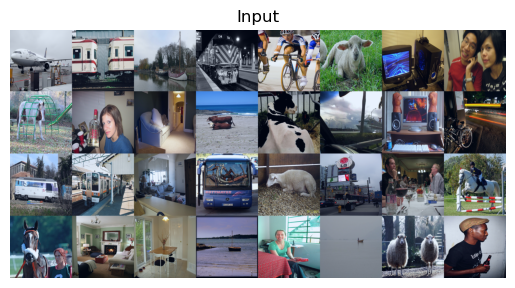

torch.Size([32, 3, 256, 256])


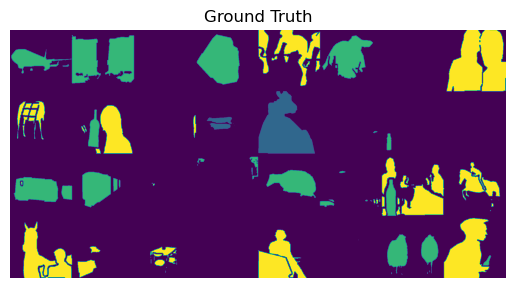

torch.Size([32, 3, 256, 256])


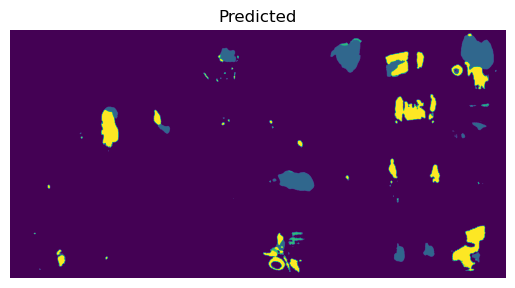

In [119]:
# TODO: Implement visualization

#model = Unet('resnet34', num_classes=1)
#model.load_state_dict(torch.load(save_path))
#model.eval() # set to evaluation mode

# Visualize validation sample
sample = next(iter(test_loader))
x = sample['image'].float().cuda() ## x.shape==[32, 3, 256, 256]
y_pred, y = model(x), sample['mask'] ##y_pred.shape== [32, 21, 256, 256], y.shape==[32, 256, 256]

y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction y_pred.shape== [32, 256, 256]

# plt.figure(figsize=(4,8))
##print(sample['image'].shape)
plt.imshow(make_grid(sample['image'], padding=0, normalize=True).permute((1, 2, 0))) ##shape==[32, 3, 256, 256]
plt.axis('off')
plt.title("Input")
plt.show()


# plt.figure(figsize=(4,8))
img_mask = decode_segmap(y).clone().detach().permute((0, 3, 1, 2)) ##shape==[32, 3, 256, 256]
#print(img_mask.shape)
plt.imshow(make_grid(img_mask, padding=0).permute((1, 2, 0))[:,:,0])
plt.axis('off')
plt.title("Ground Truth")
plt.show()


# plt.figure(figsize=(4,8))
img_pred = decode_segmap(y_pred.detach().cpu()).clone().detach().permute((0, 3, 1, 2)) ##shape==[32, 3, 256, 256]
#print(img_pred.shape)
plt.imshow(make_grid(img_pred, padding=0).permute((1, 2, 0))[:,:,0])
plt.axis('off')
plt.title("Predicted")
plt.show()